In [1]:
import numpy as np
from PIL import Image
import pandas as pd
import cv2
import os 
import matplotlib.pyplot as plt
import pydicom

# Read the CSV file from specifix path in external CD
breast_level_annotations = pd.read_csv('E:/PhD/V_M_Dataset/breast-level_annotations.csv')
# Read the CSV file
finding_annotations = pd.read_csv('E:/PhD/V_M_Dataset/finding_annotations.csv')
metadata = pd.read_csv('E:/PhD/V_M_Dataset/metadata.csv')
#for our interes we create the new DB with important columns in owr interes.
selected_columns_BLA = breast_level_annotations[[ 'study_id' , 'series_id', 'image_id', 'breast_birads', 'split','laterality' , 'view_position', 'breast_density']]

metadata.head()

,SOP Instance UID,Series Instance UID,SOP Instance UID.1,Patient's Age,View Position,Image Laterality,Photometric Interpretation,Rows,Columns,Imager Pixel Spacing,...,Pixel Padding Value,Pixel Padding Range Limit,Window Center,Window Width,Rescale Intercept,Rescale Slope,Rescale Type,Window Center & Width Explanation,Manufacturer,Manufacturer's Model Name
0,d8125545210c08e1b1793a5af6458ee2,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,053Y,CC,L,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,0,NaN,1662,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
1,290c658f4e75a3f83ec78a847414297c,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,053Y,MLO,L,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,0,NaN,1664,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
2,cd0fc7bc53ac632a11643ac4cc91002a,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,053Y,CC,R,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,0,NaN,1600,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
3,71638b1e853799f227492bfb08a01491,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,053Y,MLO,R,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,0,NaN,1654,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
4,dd9ce3288c0773e006a294188aadba8e,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,042Y,CC,L,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,0,NaN,1580,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration


### Function which delete text (Labels) posible writen in images

In [2]:

def delete_text_writen_in_image(image, window_size=(500, 500)):
    # check for images -> grayscale
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image.copy()

    h, w = gray_image.shape

    # Dritaret
    top_left = gray_image[:window_size[0], :window_size[1]]
    top_right = gray_image[:window_size[0], w-window_size[1]:]

    # Gjej vlerat maksimale në secilën dritare
    max_left = np.max(top_left)
    max_right = np.max(top_right)

    # Kontrollo nëse të gjithë pikselat janë të barabartë me max
    if np.all(top_left == max_left):
        gray_image[:window_size[0], :window_size[1]] = 0

    if np.all(top_right == max_right):
        gray_image[:window_size[0], w-window_size[1]:] = 0

    return gray_image


### Function which delete big begraund, -> crop to ROI_1

In [3]:

def crop_to_roi(original_image, return_mask=False):
    """
    Bën crop një imazh mammografik bazuar në zonën ROI më të madhe (pikselat >0).

    Parametrat:
        original_image (ndarray): Imazhi grayscale (jo RGB).
        return_mask (bool): Nëse është True, kthen edhe maskën e crop-uar.

    Kthen:
        cropped_image (ndarray): Imazhi i crop-uar.
        cropped_mask (ndarray, opsionale): Maskë e crop-uar nëse return_mask=True.
    """
    # Krijo maskën binare nga imazhi
    _, binary_mask = cv2.threshold(original_image, 1, 255, cv2.THRESH_BINARY)

    # Sigurohu që maska është binare
    mask = (binary_mask > 0).astype(np.uint8)

    # Identifiko komponentët e lidhur
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

    if num_labels <= 1:
        # Vetëm background = 0
        raise ValueError("Maska nuk ka zona aktive (ROI).")

    # Gjej komponentin me sipërfaqen më të madhe (përveç background)
    largest_idx = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

    x, y, w, h, area = stats[largest_idx]

    # Crop imazhin origjinal
    cropped_image = original_image[y:y+h, x:x+w]

    if return_mask:
        cropped_mask = binary_mask[y:y+h, x:x+w]
        return cropped_image, cropped_mask

    return cropped_image


### Function which create histograme for images

In [4]:
def histogram(image):
    """
    Llogarit histogramin e një imazhi grayscale nga 1 deri në 255.
    Kthen listë tuplesh (intensitet, frekuencë).
    """
    # Sigurohemi që është grayscale
    if len(image.shape) != 2:
        raise ValueError("Input duhet të jetë imazh bardh e zi (grayscale)")

    # Llogarit histogramin me bins fikse nga 1 në 255
    counts, bins = np.histogram(image, bins=np.arange(1, 257))  # 1–255 (256 është kufiri i sipërm)
    
    # Kombino në tuple (intensitet, numërim)
    H = list(zip(bins[:-1].astype(int), counts.tolist()))
    
    return H


### Function used to calculate Shanon Entropy


In [5]:
def shannon_entropy(arr, bins=256):
    """
    Compute Shannon entropy of a NumPy array.
    Parameters:
        arr : np.ndarray
            Input array (e.g., image or feature values).
        bins : int
            Number of bins for histogram (default 256).
    Returns:
        entropy : float
    """
    # Flatten the array
    arr = arr.ravel()
    arr = arr[(arr >= 1)]


    # Compute histogram (probability distribution)
    hist, _ = np.histogram(arr, bins=bins, density=True)
    
    # Avoid log(0) by filtering zeros
    hist = hist[hist > 0]

    # Shannon entropy
    entropy = -np.sum(hist * np.log2(hist))
    return entropy

### Function used to create poliogon in image and to extract region inside this poligon -> ROI_2

In [30]:
from skimage import data
from matplotlib.path import Path

def vizato_poligon_dhe_mask(image):
    """
    Merr një imazh bardh e zi (numpy array),
    llogarit pikat k, p, q, l, s, vizaton poligonin,
    dhe kthen imazhin e maskuar vetëm brenda poligonit.
    """
    N, M = image.shape
    mea = N // 2   # rreshti i mesit
    
    # --------------------
    # Gjetja e k, p, q
    # --------------------
    threshold = 0
    # k: pika e parë ≠ 0 kur ecim në rreshtin N/2 nga e djathta
    k = None
    row_mid = image[mea, :]
    for j in range(M-1, -1, -1):
        if row_mid[j] > threshold:
            k = j+1 if j < M-1 else M
            break
    if k is None:
        k = M // 2   # default fallback
    
    # p: pozicioni i parë ≠ 0 në kolonën M/2 nga lart
    p = None
    col_mid = image[:, M//2]
    for i in range(N):
        if col_mid[i] > threshold:
            p = i
            break
    if p is None:
        p = N // 4   # fallback
    
    # q: pozicioni i parë ≠ 0 në kolonën M/2 nga fundi
    q = None
    for i in range(mea, N-3):
        if col_mid[i] == threshold:
            q = i
            break
    if q is None:
        q = 3 * N // 4   # fallback
    
    # l: pika e parë ≠ 0 kur ecim në rreshtin f = (N/2+p)//2 nga e djathta
    f = (mea + p) // 2
    l = None
    row_f = image[f, :]
    for j in range(M-1, -1, -1):
        if row_f[j] > threshold:
            l = j+1 if j < M-1 else M
            break
    if l is None:
        l = M // 2   # fallback
    
    # s: pika e parë ≠ 0 kur ecim në rreshtin g = (q+N/2)//2 nga e djathta
    g = (q + mea) // 2
    s = None
    row_g = image[g, :]
    for j in range(M-1, -1, -1):
        if row_g[j] > threshold:
            s = j+1 if j < M-1 else M
            break
    if s is None:
        s = M // 2   # fallback

    print(f"k = {k}, p = {p}, q = {q}, l = {l}, s = {s}")

    # --------------------
    # Ndërtimi i poligonit
    # --------------------
    polygon = np.array([
        [mea, 0],
        [p, M//4],
        [p, M//2],
        [(mea+p)//2, l],
        [mea, k],
        [(q+mea)//2, s],
        [q, M//2],
        [q, M//4],
        [mea, 0]
    ])

    # --------------------
    # Krijimi i maskës
    # --------------------
    Y, X = np.mgrid[:N, :M]
    points = np.vstack((Y.flatten(), X.flatten())).T
    path = Path(polygon[:, [0, 1]])  # kujdes renditja (row, col) -> (y, x)
    mask = path.contains_points(points).reshape(N, M)

    # aplikojmë maskën mbi imazh
    masked_image = np.zeros_like(image)
    masked_image[mask] = image[mask]

    # --------------------
    # Vizualizimi
    # --------------------
    #plt.figure(figsize=(10,5))

    # imazhi origjinal + poligon
    #plt.subplot(1,2,1)
    #plt.imshow(image, cmap="gray")
    #plt.plot(polygon[:,1], polygon[:,0], 'r-', linewidth=2)
    #plt.title("Poligoni mbi imazh")

    # imazhi i maskuar
    #plt.subplot(1,2,2)
    #plt.imshow(masked_image, cmap="gray")
    #plt.title("Imazhi i filtruar brenda poligonit")

    #plt.show()

    return masked_image


### Function created to check for negative images:

In [7]:
from collections import Counter

def Check_for_negativ_image(image):
    image = np.array(image)
    v = image[:, image.shape[1]-5]
    # Vlera më e shpeshtë
    mode_val, count = Counter(v).most_common(1)[0]
    perc = count / len(v) * 100
    print(perc, mode_val)
    print(v)
    if mode_val > 250:
        return  255 - image
    else:
        return image


### Function Createt to calvulate Bimodality and extracted other features from images

In [53]:
'''''Quantitative assessment of histogram's "bimodality" property.
One defines bimodality as the relative decrease of quantisation error between 
the 1-level and the 2-level quantisation of the histogram. 
Let E1star(H) be the 1-level quantisation error of histogram H and E2star(H) the 2-level one.
  
              Bimodality(H) = ( E1star(H) - E2star(H) ) / E1star


'''''

import random
from random import randrange
from scipy.stats import entropy  
from numba import jit

def bimodality(H):
    (E1, Q) = bruteForceScalarQuantisation1(H)
    (E2, Q1, Q2) = bruteForceScalarQuantisation2(H)
    DOL1, e1 = DoL_1(Q, H)
    DOL2, e_rep, e2 = DoL_2(Q1, Q2, H)
    #print(f'Dol is{DOL1}, {DOL2}')
    return ((E1 - E2) / E1, DOL1/DOL2, e2/e1, e1, e2, Q, Q1, Q2, E1, E2)

def DoL_1(q, H):  # DoL = "number of dark pixels" / "number of light pixels"
    #mean = (q1 + q2) // 2
    D = sum([nv for (v, nv) in H if v < q])  # amount of dark pixels
    L = sum([nv for (v, nv) in H if v > q])  # amount of light pixels
    e, e1 = entropy_split_1q(H, q)
    return (D / L, e1)


def DoL_2(q1, q2, H):  # DoL = "number of dark pixels" / "number of light pixels"
    #mean = (q1 + q2) // 2
    D = sum([nv for (v, nv) in H if v <= q1])  # amount of dark pixels
    L = sum([nv for (v, nv) in H if v >= q2])  # amount of light pixels
    e1, e2 = entropy_split_2q(H, q1, q2)

    DOL = D / L
    e_rep = np.abs(e1 - e2) / e2
    return (DOL, e_rep, e2)

def entropy_split_2q(H, q1, q2):
    """
    Compute Shannon entropy of histogram in two parts:
    - 1 to k
    - k+1 to 255
    """
    # Convert histogram (list of tuples) to probabilities
    values = np.array([v for (v, _) in H], dtype=float)
    counts = np.array([nv for (_, nv) in H], dtype=float)

    # Normalize to probabilities
    p = counts / np.sum(counts)

    # Split histogram
    part1 = p[values <= q1]
    part2 = p[values > q2]

    # Avoid log(0)
    part1 = part1[part1 > 0]
    part2 = part2[part2 > 0]

    # Shannon entropy
    entropy_1 = entropy(part1, base=2)
    entropy_2 = entropy(part2, base=2)

    return entropy_1, entropy_2


def entropy_split_1q(H, q):
    """
    Compute Shannon entropy of histogram in two parts:
    - 1 to k
    - k+1 to 255
    """
    # Convert histogram (list of tuples) to probabilities
    values = np.array([v for (v, _) in H], dtype=float)
    counts = np.array([nv for (_, nv) in H], dtype=float)

    # Normalize to probabilities
    p = counts / np.sum(counts)

    # Split histogram
    part1 = p[values <= q]
    part2 = p[values > q]

    # Avoid log(0)
    part1 = part1[part1 > 0]
    part2 = part2[part2 > 0]

    # Shannon entropy
    entropy_1 = entropy(part1, base=2)
    entropy_2 = entropy(part2, base=2)

    return entropy_1, entropy_2

@jit(nopython = True)
def bruteForceScalarQuantisation1(H):
    Estar, qstar = np.inf, -1
    V = [v for (v, nv) in H]
    for q in range(0, len(V) - 1):
        E = sum([abs(v - q) * nv for (v, nv) in H])
        if E < Estar:
            qstar = q
            Estar = E
    return (Estar, qstar)

@jit(nopython = True)
def bruteForceScalarQuantisation2(H):
    EQstar, q1star, q2star = np.inf, -1, -1
    V = sorted([v for (v, nv) in H])
    for i in range(0, len(V) - 1):
        for j in range(i + 1, len(V)):
            q1, q2 = V[i], V[j]
            vmed = (q1 + q2) // 2
            EQ = sum([abs(v - q1) * nv for (v, nv) in H if v <= vmed]) + \
                 sum([abs(v - q2) * nv for (v, nv) in H if v > vmed])
            if EQ < EQstar:
                EQstar, q1star, q2star = EQ, q1, q2
    return (EQstar, q1star, q2star)

def threshold(H, t):
    return [(v, nv) for (v, nv) in H if v >= t]

def main():
    H = [(v, randrange(10, 500)) for v in range(256)]
    print("small : bimodality(H)=", end="")
    print(bimodality(H))

    H = [(v, randrange(10, 500)) for v in range(128)] + \
        [(v, randrange(10, 500)) for v in range(192, 256)]
    H = threshold(H, 50)
    print("medium : bimodality(H)=", end="")
    print(bimodality(H))

    H = [(v, randrange(10, 50)) for v in range(50)] + \
        [(v, randrange(10, 50)) for v in range(206, 256)]
    H = threshold(H, 50)
    print("high : bimodality(H)=", end="")
    print(bimodality(H))

main()


small : bimodality(H)=

C:\Users\Perdorues\.conda\envs\pytorchenv\lib\site-packages\numba\core\ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'H' of function 'bruteForceScalarQuantisation1'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\Users\Perdorues\AppData\Local\Temp\ipykernel_20696\2346605684.py", line 97:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\Perdorues\.conda\envs\pytorchenv\lib\site-packages\numba\core\ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'H' of function 'bruteForceScalarQuantisation2'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-

(0.5222179694663065, 1.0136364043481962, 0.8531550425638986, 6.753221591747741, 5.761545054550983, 124, 59, 188, 4062725.0, 1941097.0)
medium : bimodality(H)=(0.7175957508796307, 0.7237697773091009, 0.8096260987482784, 5.96465066860854, 4.829136851221842, 115, 83, 221, 2231050.0, 630058.0)
high : bimodality(H)=(0.9650794045590777, 0.0, 0.7154344828344443, 5.4758110722848485, 3.917584062599235, 48, 215, 238, 241233.0, 8424.0)


### We selected images from the Mammomat Inspiration device, specifically those acquired in the CC modality.

In [12]:
#//////////////////////////////////////////////////////////////////////////
Mammomat_Inspiration= selected_columns_BLA.loc[metadata["Manufacturer's Model Name"] == 'Mammomat Inspiration']
selected_columns_BLA_CC = Mammomat_Inspiration.loc[Mammomat_Inspiration['view_position'] == 'CC']
#  ndarë sipas Density
Dens_A = selected_columns_BLA_CC.loc[selected_columns_BLA_CC['breast_density'] == 'DENSITY A']
Dens_B = selected_columns_BLA_CC.loc[selected_columns_BLA_CC['breast_density'] == 'DENSITY B']
Dens_C = selected_columns_BLA_CC.loc[selected_columns_BLA_CC['breast_density'] == 'DENSITY C']
Dens_D = selected_columns_BLA_CC.loc[selected_columns_BLA_CC['breast_density'] == 'DENSITY D']


In [23]:
def bell_sides_coverage(H, q1, q2, coverage_target=0.90):
    """
    Calculates the intensity range (width) where 90% of values lie 
    for both left and right regions defined by q1 and q2.

    Left region: from 0 to (q1+q2)/2, centered at q1
    Right region: from (q1+q2)/2 to 255, centered at q2
    """
    # Extract intensities and counts
    values = np.array([v for (v, _) in H], dtype=float)
    counts = np.array([nv for (_, nv) in H], dtype=float)
    total = np.sum(counts)

    # Convert to probability distribution
    p = counts / total
    midpoint = (q1 + q2) / 2

    # Split histogram into left and right halves
    left_mask = values <= midpoint
    right_mask = values > midpoint

    # Normalize probabilities in each side
    p_left = p[left_mask]
    v_left = values[left_mask]
    p_left /= np.sum(p_left)

    p_right = p[right_mask]
    v_right = values[right_mask]
    p_right /= np.sum(p_right)

    # Compute cumulative distributions
    cum_left = np.cumsum(p_left)
    cum_right = np.cumsum(p_right[::-1])  # reverse for right tail

    # Find 90% coverage boundaries
    left_min = v_left[np.argmax(cum_left >= (1 - coverage_target) / 2)]
    left_max = v_left[np.argmax(cum_left >= 1 - (1 - coverage_target) / 2)]
    right_max = v_right[::-1][np.argmax(cum_right >= (1 - coverage_target) / 2)]
    right_min = v_right[::-1][np.argmax(cum_right >= 1 - (1 - coverage_target) / 2)]

    return (left_max - left_min, right_max - right_min, left_min, left_max, right_min, right_max)
    

In [24]:
H = [(v, randrange(10, 500)) for v in range(128)] + \
        [(v, randrange(10, 500)) for v in range(192, 256)]
H = threshold(H, 50)
    
bm, dol, rel_e, e1, e2, Q, Q1, Q2 = bimodality(H)

coverage = bell_sides_coverage(H, Q1, Q2, coverage_target=0.90)

coverage

(70.0, 59.0, 54.0, 124.0, 194.0, 253.0)

In [54]:
# Directory containing DICOM images
dicom_directory = 'E:/PhD/V_M_Dataset/images/'
k=0
A = []

# Iterate through each image in the dataframe
for i, row in Dens_A.iloc[:].iterrows():
    
    k+=1
    # Construct the path to the DICOM image
    dicom_image_path = os.path.join(dicom_directory, row[0], row[2] + '.dicom')
        
    # Read the DICOM file
    dicom_data = pydicom.dcmread(dicom_image_path)
    dicom_pixels = dicom_data.pixel_array

    # Normalize the pixel values between 0 and 255
    normalized_pixels = ((dicom_pixels - np.min(dicom_pixels)) / 
                            (np.max(dicom_pixels) - np.min(dicom_pixels)) * 255).astype(np.uint8)
    #converti if image is negativ to positive
    image_positive = Check_for_negativ_image(normalized_pixels)
    # Apply custom preprocessing to clean the image
    clean_image_from_text = delete_text_writen_in_image(image_positive, window_size=(700, 700))
    
    if Dens_A['laterality'][i].upper() == "R":
        clean_image_from_text = cv2.flip(clean_image_from_text, 1) 
        

    image = crop_to_roi(clean_image_from_text, return_mask=False)
    image = vizato_poligon_dhe_mask(image)

    E = shannon_entropy(clean_image_from_text, bins=256)
    H = histogram(image)
    bm, dol, rel_e, e1, e2, Q, Q1, Q2, E1, E2  = bimodality(H)
    left_dist, right_dist, left_min, left_max, right_min, right_max = bell_sides_coverage(H, Q1, Q2, coverage_target=0.90)
    

    A.append((bm, dol, rel_e, e1, e2, Q, Q1, Q2, E1, E2, left_dist, right_dist, left_min, left_max, right_min, right_max))
    print(k)
    print(left_dist, right_dist)
    

100.0 0
[0 0 0 ... 0 0 0]
k = 1215, p = 244, q = 2314, l = 1266, s = 1058


C:\Users\Perdorues\.conda\envs\pytorchenv\lib\site-packages\numba\core\ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'H' of function 'bruteForceScalarQuantisation1'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\Users\Perdorues\AppData\Local\Temp\ipykernel_20696\2346605684.py", line 97:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\Perdorues\.conda\envs\pytorchenv\lib\site-packages\numba\core\ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'H' of function 'bruteForceScalarQuantisation2'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-

1
23.0 16.0
16.458214894826607 0
[  0   0   0 ... 148 148 149]
k = 1439, p = 226, q = 2478, l = 1355, s = 1295
2
29.0 14.0
100.0 0
[0 0 0 ... 0 0 0]
k = 956, p = 487, q = 2430, l = 794, s = 977
3
32.0 27.0
9.721432632177374 0
[209 217 214 ...   0   0   0]
k = 955, p = 727, q = 2554, l = 784, s = 1071
4
40.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 622, p = 859, q = 2366, l = 523, s = 612
5
22.0 25.0
25.554292211483798 0
[0 0 0 ... 0 0 0]
k = 748, p = 491, q = 1944, l = 628, s = 677
6
23.0 26.0
100.0 0
[0 0 0 ... 0 0 0]
k = 749, p = 300, q = 1758, l = 607, s = 642
7
13.0 17.0
12.45025582717453 0
[164 163 167 ...   0   0   0]
k = 601, p = 293, q = 1767, l = 741, s = 515
8
18.0 26.0
100.0 0
[0 0 0 ... 0 0 0]
k = 925, p = 335, q = 2128, l = 936, s = 789
9
24.0 19.0
5.514496873223423 0
[0 0 0 ... 0 0 0]
k = 957, p = 657, q = 2408, l = 809, s = 802
10
25.0 19.0
100.0 0
[0 0 0 ... 0 0 0]
k = 944, p = 357, q = 2152, l = 1091, s = 794
11
30.0 23.0
6.537805571347357 151
[  0   0   0 ... 120 120 122]
k

In [61]:
k=0
B = []

# Iterate through each image in the dataframe
for i, row in Dens_B.iloc[:].iterrows():
    
    k+=1
    # Construct the path to the DICOM image
    dicom_image_path = os.path.join(dicom_directory, row[0], row[2] + '.dicom')
        
    # Read the DICOM file
    dicom_data = pydicom.dcmread(dicom_image_path)
    dicom_pixels = dicom_data.pixel_array

    # Normalize the pixel values between 0 and 255
    normalized_pixels = ((dicom_pixels - np.min(dicom_pixels)) / 
                            (np.max(dicom_pixels) - np.min(dicom_pixels)) * 255).astype(np.uint8)
    #converti if image is negativ to positive
    image_positive = Check_for_negativ_image(normalized_pixels)
    # Apply custom preprocessing to clean the image
    clean_image_from_text = delete_text_writen_in_image(image_positive, window_size=(700, 700))
    
    if Dens_B['laterality'][i].upper() == "R":
        clean_image_from_text = cv2.flip(clean_image_from_text, 1) 
        

    image = crop_to_roi(clean_image_from_text, return_mask=False)
    image = vizato_poligon_dhe_mask(image)

    E = shannon_entropy(clean_image_from_text, bins=256)
    H = histogram(image)
    bm, dol, rel_e, e1, e2, Q, Q1, Q2, E1, E2  = bimodality(H)
    left_dist, right_dist, left_min, left_max, right_min, right_max = bell_sides_coverage(H, Q1, Q2, coverage_target=0.90)
    

    B.append((bm, dol, rel_e, e1, e2, Q, Q1, Q2, E1, E2, left_dist, right_dist, left_min, left_max, right_min, right_max))
    print(k)
    
 

100.0 0
[0 0 0 ... 0 0 0]
k = 1026, p = 355, q = 2225, l = 831, s = 921
1
33.37123365548607 0
[0 0 0 ... 0 0 0]
k = 906, p = 465, q = 2239, l = 734, s = 830
2
100.0 0
[0 0 0 ... 0 0 0]
k = 1239, p = 379, q = 2370, l = 1043, s = 1104
3
10.602615122228539 0
[  0   0   0 ... 158 152 153]
k = 1188, p = 424, q = 2375, l = 1000, s = 1047
4
100.0 0
[0 0 0 ... 0 0 0]
k = 1082, p = 333, q = 2137, l = 916, s = 962
5
10.631040363843093 0
[  0   0   0 ... 133 130 129]
k = 1127, p = 405, q = 2217, l = 948, s = 1017
6
100.0 0
[0 0 0 ... 0 0 0]
k = 964, p = 515, q = 2757, l = 782, s = 987
7
20.92097782831154 0
[120 120 120 ...   0   0   0]
k = 1005, p = 391, q = 2383, l = 824, s = 902
8
100.0 0
[0 0 0 ... 0 0 0]
k = 1002, p = 373, q = 1971, l = 774, s = 787
9
17.424673109721432 0
[  0   0   0 ... 152 155 155]
k = 912, p = 344, q = 2065, l = 928, s = 778
10
100.0 0
[0 0 0 ... 0 0 0]
k = 828, p = 325, q = 1855, l = 646, s = 703
11
41.47242751563388 0
[0 0 0 ... 0 0 0]
k = 817, p = 370, q = 1923, l = 67

97
100.0 0
[0 0 0 ... 0 0 0]
k = 707, p = 443, q = 1962, l = 743, s = 588
98
36.18533257532689 0
[0 0 0 ... 0 0 0]
k = 678, p = 537, q = 2036, l = 549, s = 668
99
100.0 0
[0 0 0 ... 0 0 0]
k = 865, p = 588, q = 2340, l = 694, s = 829
100
5.088118249005117 0
[  0   0   0 ... 150 148 143]
k = 971, p = 501, q = 2275, l = 978, s = 826
101
100.0 0
[0 0 0 ... 0 0 0]
k = 1211, p = 328, q = 2139, l = 934, s = 943
102
10.37521318931211 0
[  0   0   0 ... 150 150 149]
k = 816, p = 241, q = 2236, l = 893, s = 723
103
100.0 0
[0 0 0 ... 0 0 0]
k = 839, p = 565, q = 2210, l = 960, s = 726
104
7.02103467879477 149
[  0   0   0 ... 105  99  94]
k = 783, p = 510, q = 2213, l = 858, s = 662
105
33.11540648095509 0
[0 0 0 ... 0 0 0]
k = 874, p = 466, q = 2165, l = 726, s = 810
106
100.0 0
[0 0 0 ... 0 0 0]
k = 1033, p = 473, q = 2156, l = 994, s = 872
107
10.432063672541217 0
[0 0 0 ... 0 0 0]
k = 870, p = 340, q = 2035, l = 963, s = 737
108
100.0 0
[0 0 0 ... 0 0 0]
k = 829, p = 492, q = 2025, l = 666,

192
100.0 0
[0 0 0 ... 0 0 0]
k = 1745, p = 319, q = 2704, l = 1484, s = 1553
193
13.985218874360433 0
[  0   0   0 ... 136 133 137]
k = 1560, p = 285, q = 2512, l = 1405, s = 1413
194
100.0 0
[0 0 0 ... 0 0 0]
k = 830, p = 405, q = 1956, l = 691, s = 721
195
34.934621944286526 0
[94 94 95 ...  0  0  0]
k = 804, p = 482, q = 2087, l = 635, s = 745
196
100.0 0
[0 0 0 ... 0 0 0]
k = 871, p = 325, q = 1914, l = 732, s = 772
197
40.44911881750995 0
[0 0 0 ... 0 0 0]
k = 978, p = 301, q = 2004, l = 804, s = 860
198
100.0 0
[0 0 0 ... 0 0 0]
k = 1070, p = 533, q = 2351, l = 879, s = 991
199
17.11199545196134 0
[  0   0   0 ... 151 152 154]
k = 1030, p = 391, q = 2176, l = 964, s = 868
200
100.0 0
[0 0 0 ... 0 0 0]
k = 818, p = 800, q = 2340, l = 668, s = 822
201
20.60830017055145 0
[127 128 127 ...   0   0   0]
k = 739, p = 920, q = 2588, l = 619, s = 852
202
100.0 0
[0 0 0 ... 0 0 0]
k = 925, p = 833, q = 2500, l = 771, s = 946
203
23.877202956225126 0
[0 0 0 ... 0 0 0]
k = 1029, p = 377, q

5.400795906765207 151
[  0   0   0 ... 136 135 135]
k = 784, p = 630, q = 2232, l = 632, s = 863
288
100.0 0
[0 0 0 ... 0 0 0]
k = 1096, p = 811, q = 2700, l = 905, s = 1121
289
29.846503695281413 0
[101 100 100 ...   0   0   0]
k = 1196, p = 371, q = 2345, l = 1027, s = 1121
290
100.0 0
[0 0 0 ... 0 0 0]
k = 829, p = 343, q = 1934, l = 684, s = 757
291
42.52416145537237 0
[0 0 0 ... 0 0 0]
k = 706, p = 350, q = 1905, l = 588, s = 682
292
100.0 0
[0 0 0 ... 0 0 0]
k = 1006, p = 398, q = 2096, l = 840, s = 970
293
8.357021034678795 0
[  0   0   0 ... 150 152 152]
k = 1123, p = 379, q = 2070, l = 957, s = 995
294
100.0 0
[0 0 0 ... 0 0 0]
k = 1079, p = 385, q = 2148, l = 1016, s = 905
295
7.447413303013076 147
[  0   0   0 ... 121 122 123]
k = 1160, p = 552, q = 2353, l = 925, s = 1140
296
100.0 0
[0 0 0 ... 0 0 0]
k = 835, p = 656, q = 2394, l = 701, s = 868
297
25.071063104036384 0
[142 142 142 ...   0   0   0]
k = 740, p = 684, q = 2445, l = 625, s = 913
298
100.0 0
[0 0 0 ... 0 0 0]


384
100.0 0
[0 0 0 ... 0 0 0]
k = 861, p = 727, q = 2315, l = 782, s = 746
385
6.424104604889141 0
[155 152 156 ...   0   0   0]
k = 815, p = 745, q = 2336, l = 649, s = 825
386
100.0 0
[0 0 0 ... 0 0 0]
k = 1122, p = 506, q = 2403, l = 1009, s = 928
387
7.532689027856737 0
[  0   0   0 ... 144 143 139]
k = 871, p = 420, q = 2234, l = 913, s = 750
388
100.0 0
[0 0 0 ... 0 0 0]
k = 888, p = 789, q = 2565, l = 737, s = 991
389
15.832859579306424 0
[0 0 0 ... 0 0 0]
k = 1065, p = 488, q = 2408, l = 864, s = 1089
390
100.0 0
[0 0 0 ... 0 0 0]
k = 895, p = 750, q = 2486, l = 802, s = 750
391
13.132461625923819 0
[  0   0   0 ... 148 155 157]
k = 805, p = 319, q = 2011, l = 947, s = 691
392
100.0 0
[0 0 0 ... 0 0 0]
k = 855, p = 379, q = 1875, l = 656, s = 684
393
15.918135304150086 0
[  0   0   0 ... 138 140 139]
k = 772, p = 573, q = 2035, l = 736, s = 658
394
100.0 0
[0 0 0 ... 0 0 0]
k = 1094, p = 298, q = 2016, l = 923, s = 970
395
5.884025014212621 149
[  0   0   0 ... 133 133 133]
k =

480
100.0 0
[0 0 0 ... 0 0 0]
k = 736, p = 410, q = 1787, l = 604, s = 634
481
21.31893121091529 0
[  0   0   0 ... 129 127 125]
k = 667, p = 316, q = 1648, l = 601, s = 557
482
100.0 0
[0 0 0 ... 0 0 0]
k = 515, p = 432, q = 1782, l = 438, s = 499
483
100.0 0
[0 0 0 ... 0 0 0]
k = 424, p = 256, q = 1417, l = 407, s = 383
484
49.54519613416714 0
[0 0 0 ... 0 0 0]
k = 448, p = 281, q = 1547, l = 376, s = 364
485
100.0 0
[0 0 0 ... 0 0 0]
k = 939, p = 695, q = 2300, l = 779, s = 1115
486
9.408754974417283 0
[213 210 215 ...   0   0   0]
k = 711, p = 959, q = 2502, l = 598, s = 893
487
100.0 0
[0 0 0 ... 0 0 0]
k = 648, p = 477, q = 1835, l = 546, s = 656
488
23.905628197839683 0
[143 143 142 ...   0   0   0]
k = 618, p = 635, q = 2038, l = 510, s = 634
489
100.0 0
[0 0 0 ... 0 0 0]
k = 1140, p = 362, q = 2283, l = 1070, s = 992
490
13.814667424673111 0
[  0   0   0 ... 140 143 144]
k = 1139, p = 295, q = 2204, l = 1112, s = 959
491
100.0 0
[0 0 0 ... 0 0 0]
k = 977, p = 513, q = 2184, l 

575
100.0 0
[0 0 0 ... 0 0 0]
k = 1399, p = 360, q = 2127, l = 1155, s = 1203
576
30.642410460488918 0
[0 0 0 ... 0 0 0]
k = 1493, p = 360, q = 2144, l = 1280, s = 1298
577
15.463331438317226 0
[  0   0   0 ... 144 141 142]
k = 790, p = 647, q = 2229, l = 655, s = 799
578
100.0 0
[0 0 0 ... 0 0 0]
k = 1007, p = 328, q = 2102, l = 821, s = 822
579
31.409891984081867 0
[0 0 0 ... 0 0 0]
k = 979, p = 405, q = 2143, l = 770, s = 819
580
100.0 0
[0 0 0 ... 0 0 0]
k = 819, p = 288, q = 1687, l = 652, s = 616
581
22.5412166003411 0
[  0   0   0 ... 245 244 242]
k = 812, p = 353, q = 1812, l = 654, s = 762
582
100.0 0
[0 0 0 ... 0 0 0]
k = 801, p = 498, q = 2087, l = 646, s = 727
583
23.877202956225126 0
[0 0 0 ... 0 0 0]
k = 815, p = 489, q = 2039, l = 661, s = 766
584
100.0 0
[0 0 0 ... 0 0 0]
k = 1057, p = 327, q = 2106, l = 1043, s = 898
585
8.101193860147811 148
[  0   0   0 ... 127 125 123]
k = 995, p = 348, q = 2080, l = 1100, s = 837
586
100.0 0
[0 0 0 ... 0 0 0]
k = 931, p = 473, q = 

In [62]:
k=0
C = []

# Iterate through each image in the dataframe
for i, row in Dens_C.iloc[:].iterrows():
    
    k+=1
    # Construct the path to the DICOM image
    dicom_image_path = os.path.join(dicom_directory, row[0], row[2] + '.dicom')
        
    # Read the DICOM file
    dicom_data = pydicom.dcmread(dicom_image_path)
    dicom_pixels = dicom_data.pixel_array

    # Normalize the pixel values between 0 and 255
    normalized_pixels = ((dicom_pixels - np.min(dicom_pixels)) / 
                            (np.max(dicom_pixels) - np.min(dicom_pixels)) * 255).astype(np.uint8)
    #converti if image is negativ to positive
    image_positive = Check_for_negativ_image(normalized_pixels)
    # Apply custom preprocessing to clean the image
    clean_image_from_text = delete_text_writen_in_image(image_positive, window_size=(700, 700))
    
    if Dens_C['laterality'][i].upper() == "R":
        clean_image_from_text = cv2.flip(clean_image_from_text, 1) 
        

    image = crop_to_roi(clean_image_from_text, return_mask=False)
    image = vizato_poligon_dhe_mask(image)

    E = shannon_entropy(clean_image_from_text, bins=256)
    H = histogram(image)
    bm, dol, rel_e, e1, e2, Q, Q1, Q2, E1, E2  = bimodality(H)
    left_dist, right_dist, left_min, left_max, right_min, right_max = bell_sides_coverage(H, Q1, Q2, coverage_target=0.90)
    

    C.append((bm, dol, rel_e, e1, e2, Q, Q1, Q2, E1, E2, left_dist, right_dist, left_min, left_max, right_min, right_max))
    print(k)
    print(left_dist, right_dist)
    
 

100.0 0
[0 0 0 ... 0 0 0]
k = 797, p = 472, q = 2191, l = 681, s = 790
1
39.0 35.0
24.189880613985217 0
[126 123 126 ...   0   0   0]
k = 837, p = 382, q = 1941, l = 648, s = 667
2
68.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 923, p = 894, q = 2711, l = 774, s = 1039
3
52.0 42.0
21.0062535531552 0
[100  99 101 ...   0   0   0]
k = 1042, p = 367, q = 2252, l = 861, s = 1043
4
54.0 41.0
100.0 0
[0 0 0 ... 0 0 0]
k = 975, p = 387, q = 2040, l = 772, s = 792
5
22.0 28.0
10.289937464468448 0
[0 0 0 ... 0 0 0]
k = 764, p = 507, q = 2090, l = 783, s = 638
6
23.0 27.0
100.0 0
[0 0 0 ... 0 0 0]
k = 724, p = 669, q = 2170, l = 608, s = 764
7
28.0 27.0
16.17396247868107 0
[  0   0   0 ... 160 151 150]
k = 667, p = 340, q = 1854, l = 761, s = 576
8
26.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 724, p = 470, q = 1761, l = 573, s = 639
9
34.0 27.0
42.410460488914154 0
[0 0 0 ... 0 0 0]
k = 926, p = 458, q = 1840, l = 607, s = 680
10
46.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 966, p = 352, q = 2220, l = 1019, s = 

88
41.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1057, p = 662, q = 2620, l = 888, s = 951
89
40.0 29.0
6.509380329732803 144
[ 53  57  62 ... 137 136 137]
k = 918, p = 634, q = 2317, l = 934, s = 791
90
41.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 813, p = 333, q = 1772, l = 693, s = 712
91
18.0 24.0
28.737919272313817 0
[213 232 217 ...   0   0   0]
k = 699, p = 297, q = 1738, l = 634, s = 635
92
13.0 15.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1050, p = 566, q = 2285, l = 911, s = 917
93
45.0 38.0
17.310972143263218 0
[0 0 0 ... 0 0 0]
k = 875, p = 425, q = 2010, l = 910, s = 751
94
47.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 811, p = 334, q = 1862, l = 886, s = 701
95
38.0 22.0
40.67652075042638 0
[0 0 0 ... 0 0 0]
k = 913, p = 335, q = 1899, l = 765, s = 824
96
32.0 21.0
100.0 0
[0 0 0 ... 0 0 0]
k = 884, p = 383, q = 1860, l = 711, s = 762
97
35.0 34.0
13.132461625923819 0
[  0   0   0 ... 143 148 151]
k = 756, p = 702, q = 2109, l = 614, s = 780
98
44.0 35.0
100.0 0
[0 0 0 ... 0 0 0]
k = 738, p = 376, 

175
30.0 41.0
16.742467310972142 0
[  0   0   0 ... 147 147 146]
k = 1190, p = 285, q = 2076, l = 1004, s = 1043
176
25.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 804, p = 372, q = 1799, l = 597, s = 623
177
44.0 36.0
27.544059124502557 0
[200 194 195 ...   0   0   0]
k = 619, p = 860, q = 2381, l = 529, s = 665
178
28.0 35.0
100.0 0
[0 0 0 ... 0 0 0]
k = 877, p = 286, q = 1992, l = 903, s = 752
179
29.0 26.0
33.769187038089825 0
[0 0 0 ... 0 0 0]
k = 1003, p = 345, q = 2166, l = 817, s = 864
180
31.0 26.0
100.0 0
[0 0 0 ... 0 0 0]
k = 977, p = 800, q = 2559, l = 778, s = 998
181
35.0 30.0
16.884593519044913 0
[  0   0   0 ... 124 125 124]
k = 970, p = 682, q = 2401, l = 787, s = 968
182
34.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 950, p = 504, q = 2248, l = 805, s = 892
183
27.0 35.0
6.850483229107447 0
[  0   0   0 ... 139 143 139]
k = 1016, p = 429, q = 2147, l = 837, s = 871
184
32.0 36.0
100.0 0
[0 0 0 ... 0 0 0]
k = 795, p = 310, q = 1775, l = 635, s = 669
185
29.0 23.0
47.612279704377485 

261
36.0 27.0
29.363274587834 0
[0 0 0 ... 0 0 0]
k = 933, p = 390, q = 2012, l = 840, s = 781
262
40.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 627, p = 749, q = 2051, l = 521, s = 659
263
26.0 24.0
43.234792495736215 0
[0 0 0 ... 0 0 0]
k = 687, p = 348, q = 1756, l = 575, s = 616
264
29.0 17.0
100.0 0
[0 0 0 ... 0 0 0]
k = 871, p = 786, q = 2413, l = 707, s = 958
265
27.0 26.0
38.06139852188743 0
[0 0 0 ... 0 0 0]
k = 958, p = 418, q = 2055, l = 786, s = 942
266
33.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 846, p = 476, q = 2160, l = 693, s = 835
267
37.0 36.0
17.595224559408752 0
[  0   0   0 ... 143 144 146]
k = 721, p = 298, q = 1857, l = 818, s = 613
268
32.0 39.0
100.0 0
[0 0 0 ... 0 0 0]
k = 735, p = 466, q = 2100, l = 628, s = 681
269
30.0 30.0
18.76065946560546 0
[0 0 0 ... 0 0 0]
k = 786, p = 438, q = 2076, l = 645, s = 685
270
31.0 38.0
100.0 0
[0 0 0 ... 0 0 0]
k = 799, p = 835, q = 2408, l = 684, s = 955
271
31.0 28.0
33.20068220579875 0
[96 94 94 ...  0  0  0]
k = 773, p = 631, q 

348
30.0 27.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1261, p = 390, q = 2259, l = 1062, s = 1187
349
33.0 30.0
6.79363274587834 0
[0 0 0 ... 0 0 0]
k = 1430, p = 586, q = 2435, l = 1188, s = 1228
350
39.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 771, p = 248, q = 1817, l = 922, s = 657
351
26.0 31.0
23.536100056850483 0
[0 0 0 ... 0 0 0]
k = 964, p = 301, q = 1962, l = 845, s = 795
352
30.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 747, p = 282, q = 1737, l = 621, s = 616
353
35.0 33.0
39.965889710062534 0
[0 0 0 ... 0 0 0]
k = 751, p = 433, q = 1899, l = 632, s = 694
354
32.0 35.0
100.0 0
[0 0 0 ... 0 0 0]
k = 878, p = 962, q = 2581, l = 744, s = 1075
355
42.0 32.0
32.0636725412166 0
[  0   0   0 ... 161 165 161]
k = 953, p = 269, q = 1823, l = 835, s = 877
356
32.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1183, p = 333, q = 2065, l = 930, s = 1021
357
37.0 31.0
28.453666856168276 0
[  0   0   0 ... 151 149 149]
k = 990, p = 286, q = 1965, l = 866, s = 896
358
33.0 35.0
100.0 0
[0 0 0 ... 0 0 0]
k = 870, p = 418

435
35.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 617, p = 923, q = 2369, l = 536, s = 816
436
41.0 36.0
25.895395110858445 0
[0 0 0 ... 0 0 0]
k = 734, p = 554, q = 1759, l = 609, s = 661
437
36.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 593, p = 345, q = 1825, l = 507, s = 554
438
30.0 34.0
18.959636156907333 0
[0 0 0 ... 0 0 0]
k = 499, p = 384, q = 1841, l = 418, s = 502
439
28.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 850, p = 469, q = 2072, l = 700, s = 807
440
31.0 27.0
14.269471290505969 0
[0 0 0 ... 0 0 0]
k = 838, p = 516, q = 2133, l = 749, s = 664
441
31.0 27.0
100.0 0
[0 0 0 ... 0 0 0]
k = 831, p = 775, q = 2262, l = 703, s = 896
442
44.0 33.0
18.362706083001708 0
[0 0 0 ... 0 0 0]
k = 906, p = 673, q = 2224, l = 751, s = 1107
443
62.0 39.0
100.0 0
[0 0 0 ... 0 0 0]
k = 750, p = 487, q = 1914, l = 642, s = 708
444
41.0 35.0
14.440022740193292 0
[  0   0   0 ... 148 145 146]
k = 659, p = 500, q = 1920, l = 691, s = 582
445
39.0 41.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1019, p = 317, q = 1917, l =

522
49.0 34.0
22.82546901648664 0
[0 0 0 ... 0 0 0]
k = 680, p = 454, q = 1903, l = 750, s = 588
523
35.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 941, p = 550, q = 2089, l = 780, s = 863
524
53.0 39.0
3.382603752131893 0
[79 80 80 ... 35 33 32]
k = 892, p = 605, q = 2215, l = 747, s = 884
525
41.0 40.0
100.0 0
[0 0 0 ... 0 0 0]
k = 800, p = 272, q = 1822, l = 643, s = 670
526
31.0 32.0
42.7515633882888 0
[0 0 0 ... 0 0 0]
k = 991, p = 323, q = 1762, l = 757, s = 785
527
45.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 823, p = 443, q = 2097, l = 682, s = 712
528
32.0 40.0
14.184195565662309 0
[0 0 0 ... 0 0 0]
k = 795, p = 508, q = 2020, l = 665, s = 715
529
31.0 43.0
100.0 0
[0 0 0 ... 0 0 0]
k = 979, p = 604, q = 2473, l = 790, s = 961
530
56.0 38.0
11.967026719727118 0
[  0   0   0 ... 132 130 133]
k = 964, p = 621, q = 2297, l = 780, s = 886
531
39.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 976, p = 623, q = 2281, l = 908, s = 835
532
39.0 30.0
9.494030699260945 0
[79 75 79 ...  0  0  0]
k = 899, p = 

608
48.0 40.0
7.78851620238772 0
[  0   0   0 ... 120 119 121]
k = 729, p = 526, q = 2152, l = 783, s = 634
609
38.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 858, p = 357, q = 1844, l = 671, s = 685
610
34.0 37.0
38.345650938032975 0
[0 0 0 ... 0 0 0]
k = 789, p = 342, q = 1764, l = 691, s = 648
611
32.0 36.0
100.0 0
[0 0 0 ... 0 0 0]
k = 738, p = 480, q = 2092, l = 637, s = 735
612
18.0 25.0
42.922114837976125 0
[0 0 0 ... 0 0 0]
k = 817, p = 365, q = 1900, l = 683, s = 739
613
29.0 39.0
100.0 0
[0 0 0 ... 0 0 0]
k = 760, p = 284, q = 1921, l = 891, s = 648
614
42.0 45.0
21.546333143831724 0
[  0   0   0 ... 135 134 132]
k = 832, p = 276, q = 1986, l = 866, s = 695
615
38.0 44.0
100.0 0
[0 0 0 ... 0 0 0]
k = 683, p = 332, q = 1788, l = 842, s = 598
616
33.0 31.0
11.654349061967027 0
[0 0 0 ... 0 0 0]
k = 869, p = 368, q = 1847, l = 703, s = 769
617
33.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 722, p = 367, q = 1787, l = 613, s = 630
618
35.0 46.0
30.130756111426948 0
[  0   0   0 ... 125 125 124

695
26.0 31.0
12.73450824332007 0
[  0   0   0 ... 148 147 148]
k = 1106, p = 290, q = 2230, l = 1081, s = 982
696
26.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 886, p = 286, q = 1944, l = 722, s = 732
697
41.0 30.0
10.261512222853893 0
[  0   0   0 ... 108 107 105]
k = 921, p = 303, q = 2017, l = 726, s = 765
698
33.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1126, p = 559, q = 2238, l = 1001, s = 884
699
29.0 36.0
23.166571915861283 0
[0 0 0 ... 0 0 0]
k = 1039, p = 554, q = 2089, l = 844, s = 974
700
30.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 787, p = 358, q = 1973, l = 658, s = 697
701
31.0 28.0
15.548607163160888 0
[0 0 0 ... 0 0 0]
k = 841, p = 534, q = 2136, l = 692, s = 787
702
40.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 838, p = 309, q = 1868, l = 706, s = 715
703
29.0 31.0
30.84138715179079 0
[0 0 0 ... 0 0 0]
k = 823, p = 692, q = 2281, l = 675, s = 825
704
33.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 683, p = 278, q = 1620, l = 598, s = 544
705
56.0 47.0
15.605457646389995 0
[  0   0   0 ... 171 17

782
45.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 849, p = 434, q = 2021, l = 671, s = 674
783
48.0 33.0
7.959067652075043 0
[  0   0   0 ... 129 130 130]
k = 555, p = 321, q = 1773, l = 652, s = 489
784
27.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1197, p = 509, q = 2359, l = 973, s = 1118
785
32.0 34.0
15.889710062535531 0
[106 107 107 ...   0   0   0]
k = 1228, p = 536, q = 2369, l = 998, s = 1184
786
35.0 40.0
100.0 0
[0 0 0 ... 0 0 0]
k = 929, p = 305, q = 1818, l = 740, s = 772
787
32.0 32.0
20.210346787947696 0
[0 0 0 ... 0 0 0]
k = 914, p = 335, q = 1896, l = 735, s = 774
788
33.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 679, p = 357, q = 1857, l = 773, s = 587
789
35.0 29.0
20.011370096645823 0
[  0   0   0 ... 141 139 138]
k = 740, p = 417, q = 2047, l = 660, s = 618
790
27.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 703, p = 508, q = 2073, l = 567, s = 681
791
27.0 29.0
18.02160318362706 0
[  0   0   0 ... 136 135 134]
k = 685, p = 395, q = 1927, l = 722, s = 585
792
25.0 32.0
100.0 0
[0 0 0 ... 0 

869
38.0 29.0
12.876634451392837 0
[0 0 0 ... 0 0 0]
k = 980, p = 276, q = 2014, l = 891, s = 867
870
32.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 767, p = 356, q = 1932, l = 601, s = 652
871
25.0 30.0
34.25241614553723 0
[0 0 0 ... 0 0 0]
k = 843, p = 543, q = 2028, l = 695, s = 920
872
21.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 878, p = 316, q = 1938, l = 733, s = 806
873
34.0 31.0
34.56509380329732 0
[0 0 0 ... 0 0 0]
k = 893, p = 324, q = 1833, l = 732, s = 777
874
38.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 741, p = 468, q = 2041, l = 776, s = 629
875
27.0 38.0
5.6850483229107445 151
[  0   0   0 ... 149 151 149]
k = 734, p = 973, q = 2536, l = 596, s = 767
876
31.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 871, p = 607, q = 2364, l = 742, s = 878
877
29.0 25.0
31.182490051165434 0
[0 0 0 ... 0 0 0]
k = 912, p = 460, q = 2199, l = 763, s = 913
878
28.0 27.0
100.0 0
[0 0 0 ... 0 0 0]
k = 714, p = 394, q = 1884, l = 605, s = 628
879
32.0 33.0
24.758385446276293 0
[129 129 130 ...   0   0   0]
k = 712,

956
38.0 28.0
7.191586128482092 144
[  0   0   0 ... 139 139 137]
k = 1239, p = 513, q = 2337, l = 1021, s = 983
957
47.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1008, p = 351, q = 1877, l = 827, s = 838
958
32.0 28.0
25.326890278567365 0
[0 0 0 ... 0 0 0]
k = 1044, p = 404, q = 1983, l = 899, s = 986
959
30.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 994, p = 448, q = 2228, l = 832, s = 902
960
42.0 36.0
27.515633882888004 0
[  0   0   0 ... 119 118 118]
k = 978, p = 254, q = 2005, l = 822, s = 843
961
36.0 38.0
100.0 0
[0 0 0 ... 0 0 0]
k = 899, p = 435, q = 2235, l = 739, s = 847
962
25.0 29.0
5.713473564525298 0
[139 140 139 ...   0   0   0]
k = 894, p = 721, q = 2494, l = 735, s = 990
963
25.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 626, p = 472, q = 1781, l = 704, s = 547
964
45.0 47.0
36.81068789084707 0
[0 0 0 ... 0 0 0]
k = 785, p = 475, q = 1776, l = 590, s = 578
965
69.0 48.0
100.0 0
[0 0 0 ... 0 0 0]
k = 978, p = 216, q = 2104, l = 856, s = 882
966
29.0 42.0
100.0 0
[0 0 0 ... 0 0 0]
k = 12

1041
29.0 23.0
41.50085275724844 0
[0 0 0 ... 0 0 0]
k = 954, p = 289, q = 1907, l = 828, s = 855
1042
26.0 23.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1058, p = 828, q = 2838, l = 877, s = 1127
1043
34.0 32.0
8.24332006822058 0
[ 0  0  0 ... 91 91 91]
k = 1112, p = 433, q = 2338, l = 1031, s = 974
1044
32.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 687, p = 349, q = 1761, l = 838, s = 624
1045
68.0 36.0
33.62706083001705 0
[0 0 0 ... 0 0 0]
k = 822, p = 373, q = 1824, l = 643, s = 637
1046
51.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 862, p = 272, q = 1729, l = 656, s = 643
1047
33.0 29.0
42.922114837976125 0
[0 0 0 ... 0 0 0]
k = 721, p = 295, q = 1717, l = 632, s = 611
1048
16.0 19.0
100.0 0
[0 0 0 ... 0 0 0]
k = 688, p = 302, q = 1771, l = 719, s = 592
1049
28.0 29.0
40.164866401364414 0
[0 0 0 ... 0 0 0]
k = 736, p = 406, q = 1846, l = 619, s = 680
1050
28.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 880, p = 258, q = 1789, l = 793, s = 796
1051
18.0 22.0
6.026151222285389 144
[  0   0   0 ... 150 147 146]
k 

1127
36.0 35.0
100.0 0
[0 0 0 ... 0 0 0]
k = 999, p = 413, q = 2018, l = 782, s = 823
1128
34.0 30.0
27.856736782262647 0
[0 0 0 ... 0 0 0]
k = 963, p = 558, q = 2306, l = 800, s = 905
1129
31.0 23.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1163, p = 281, q = 2127, l = 1165, s = 992
1130
50.0 39.0
4.320636725412165 130
[123 124 124 ... 112 112 109]
k = 1069, p = 311, q = 2080, l = 1152, s = 885
1131
47.0 36.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1080, p = 611, q = 2577, l = 919, s = 993
1132
40.0 37.0
7.532689027856737 141
[79 78 79 ...  0  0  0]
k = 1260, p = 388, q = 2377, l = 986, s = 1023
1133
52.0 38.0
100.0 0
[0 0 0 ... 0 0 0]
k = 809, p = 461, q = 2136, l = 670, s = 756
1134
36.0 36.0
35.04832291074474 0
[0 0 0 ... 0 0 0]
k = 970, p = 373, q = 2081, l = 782, s = 868
1135
44.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1002, p = 443, q = 2183, l = 802, s = 952
1136
48.0 35.0
25.952245594087547 0
[0 0 0 ... 0 0 0]
k = 988, p = 542, q = 2191, l = 797, s = 970
1137
46.0 36.0
100.0 0
[0 0 0 ... 0 0 0]
k = 813

1213
44.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 919, p = 323, q = 1949, l = 938, s = 795
1214
32.0 26.0
10.062535531552017 0
[  0   0   0 ... 113 113 112]
k = 847, p = 289, q = 1901, l = 959, s = 723
1215
31.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 684, p = 303, q = 1708, l = 562, s = 597
1216
26.0 25.0
46.105741898806144 0
[0 0 0 ... 0 0 0]
k = 668, p = 327, q = 1676, l = 547, s = 571
1217
23.0 25.0
100.0 0
[0 0 0 ... 0 0 0]
k = 846, p = 824, q = 2368, l = 701, s = 894
1218
39.0 35.0
39.22683342808414 0
[0 0 0 ... 0 0 0]
k = 826, p = 491, q = 1933, l = 681, s = 784
1219
29.0 27.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1214, p = 670, q = 2818, l = 1028, s = 1062
1220
41.0 37.0
5.002842524161456 151
[153 157 160 ...  86  85  86]
k = 1267, p = 725, q = 2755, l = 1059, s = 1106
1221
43.0 41.0
100.0 0
[0 0 0 ... 0 0 0]
k = 733, p = 263, q = 1767, l = 847, s = 633
1222
25.0 27.0
36.10005685048323 0
[0 0 0 ... 0 0 0]
k = 871, p = 242, q = 1742, l = 724, s = 721
1223
31.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 7

1299
42.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 996, p = 358, q = 2094, l = 803, s = 936
1300
28.0 30.0
27.799886299033545 0
[138 139 139 ...   0   0   0]
k = 838, p = 764, q = 2395, l = 699, s = 1032
1301
32.0 27.0
100.0 0
[0 0 0 ... 0 0 0]
k = 797, p = 252, q = 1649, l = 632, s = 657
1302
29.0 27.0
43.348493462194426 0
[0 0 0 ... 0 0 0]
k = 791, p = 328, q = 1697, l = 649, s = 763
1303
28.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 819, p = 373, q = 1946, l = 650, s = 681
1304
28.0 26.0
38.74360432063673 0
[0 0 0 ... 0 0 0]
k = 821, p = 426, q = 1867, l = 639, s = 660
1305
30.0 24.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1042, p = 313, q = 2362, l = 944, s = 903
1306
37.0 27.0
13.416714042069358 0
[  0   0   0 ... 141 149 149]
k = 1063, p = 390, q = 2542, l = 908, s = 943
1307
36.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1127, p = 372, q = 2023, l = 867, s = 902
1308
45.0 35.0
8.669698692438885 0
[130 129 131 ... 111 112 110]
k = 923, p = 361, q = 2064, l = 939, s = 787
1309
39.0 35.0
100.0 0
[0 0 0 ... 0 0

1384
31.0 23.0
45.25298465036953 0
[0 0 0 ... 0 0 0]
k = 1020, p = 334, q = 1765, l = 821, s = 860
1385
31.0 22.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1016, p = 1072, q = 2939, l = 845, s = 1325
1386
37.0 37.0
28.652643547470152 0
[144 146 144 ...   0   0   0]
k = 1316, p = 399, q = 2401, l = 1054, s = 1404
1387
38.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1148, p = 396, q = 2129, l = 947, s = 1112
1388
33.0 37.0
30.159181353041504 0
[0 0 0 ... 0 0 0]
k = 1096, p = 425, q = 2296, l = 890, s = 1152
1389
34.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 907, p = 338, q = 1848, l = 730, s = 766
1390
40.0 38.0
34.081864695849916 0
[0 0 0 ... 0 0 0]
k = 842, p = 644, q = 2080, l = 680, s = 836
1391
36.0 36.0
100.0 0
[0 0 0 ... 0 0 0]
k = 724, p = 284, q = 1670, l = 627, s = 617
1392
17.0 23.0
49.14724275156338 0
[0 0 0 ... 0 0 0]
k = 715, p = 274, q = 1647, l = 613, s = 610
1393
20.0 23.0
100.0 0
[0 0 0 ... 0 0 0]
k = 796, p = 907, q = 2366, l = 661, s = 861
1394
26.0 26.0
25.667993177942012 0
[  0   0   0 ... 1

1470
18.0 16.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1192, p = 523, q = 2205, l = 1124, s = 1002
1471
38.0 33.0
17.822626492325185 0
[0 0 0 ... 0 0 0]
k = 1122, p = 350, q = 2086, l = 1147, s = 923
1472
34.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 761, p = 874, q = 2467, l = 713, s = 659
1473
47.0 38.0
18.902785673678228 0
[113 110 113 ...   0   0   0]
k = 657, p = 1071, q = 2607, l = 558, s = 728
1474
33.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 905, p = 315, q = 2149, l = 812, s = 796
1475
38.0 41.0
17.140420693575894 0
[  0   0   0 ... 149 148 148]
k = 844, p = 258, q = 2164, l = 867, s = 722
1476
32.0 45.0
100.0 0
[0 0 0 ... 0 0 0]
k = 816, p = 403, q = 1999, l = 675, s = 774
1477
34.0 34.0
39.22683342808414 0
[0 0 0 ... 0 0 0]
k = 807, p = 413, q = 2004, l = 676, s = 799
1478
39.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 726, p = 714, q = 2281, l = 600, s = 734
1479
37.0 33.0
6.054576463899943 0
[139 140 140 ... 155 158 162]
k = 770, p = 419, q = 2054, l = 641, s = 732
1480
32.0 32.0
100.0 0
[0 0 0 ... 0

7.390562819783968 0
[  0   0   0 ... 171 173 164]
k = 949, p = 348, q = 2140, l = 975, s = 834
1556
41.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1226, p = 308, q = 2090, l = 1028, s = 1092
1557
33.0 35.0
38.2035247299602 0
[0 0 0 ... 0 0 0]
k = 1164, p = 285, q = 1963, l = 970, s = 979
1558
30.0 38.0
100.0 0
[0 0 0 ... 0 0 0]
k = 926, p = 616, q = 2266, l = 736, s = 735
1559
34.0 28.0
26.86185332575327 0
[0 0 0 ... 0 0 0]
k = 799, p = 744, q = 2369, l = 654, s = 895
1560
52.0 40.0
100.0 0
[0 0 0 ... 0 0 0]
k = 797, p = 386, q = 2036, l = 804, s = 700
1561
28.0 30.0
6.225127913587265 0
[  0   0   0 ... 138 140 141]
k = 834, p = 411, q = 2187, l = 812, s = 716
1562
29.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 889, p = 295, q = 1759, l = 707, s = 726
1563
57.0 44.0
29.732802728823195 0
[0 0 0 ... 0 0 0]
k = 642, p = 931, q = 2370, l = 550, s = 880
1564
44.0 36.0
100.0 0
[0 0 0 ... 0 0 0]
k = 821, p = 293, q = 1669, l = 647, s = 653
1565
36.0 27.0
47.27117680500284 0
[0 0 0 ... 0 0 0]
k = 692, p = 2

1641
31.0 37.0
40.93234792495736 0
[0 0 0 ... 0 0 0]
k = 577, p = 507, q = 1876, l = 483, s = 548
1642
33.0 35.0
100.0 0
[0 0 0 ... 0 0 0]
k = 831, p = 303, q = 1782, l = 673, s = 698
1643
27.0 28.0
43.121091529278 0
[0 0 0 ... 0 0 0]
k = 784, p = 319, q = 1756, l = 648, s = 697
1644
23.0 25.0
100.0 0
[0 0 0 ... 0 0 0]
k = 850, p = 814, q = 2559, l = 702, s = 918
1645
43.0 41.0
14.155770324047753 0
[0 0 0 ... 0 0 0]
k = 871, p = 865, q = 2608, l = 729, s = 945
1646
42.0 37.0
100.0 0
[0 0 0 ... 0 0 0]
k = 803, p = 528, q = 1878, l = 649, s = 772
1647
28.0 30.0
12.279704377487208 0
[0 0 0 ... 0 0 0]
k = 846, p = 518, q = 1945, l = 757, s = 601
1648
29.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 972, p = 332, q = 1958, l = 794, s = 900
1649
28.0 26.0
34.02501421262081 0
[  0   0   0 ... 145 147 148]
k = 959, p = 225, q = 1828, l = 852, s = 819
1650
28.0 25.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1094, p = 433, q = 2163, l = 893, s = 809
1651
43.0 38.0
8.811824900511654 0
[  0   0   0 ... 142 142 147]
k 

14.269471290505969 0
[ 0  0  0 ... 98 98 97]
k = 1176, p = 514, q = 2360, l = 973, s = 1160
1728
23.0 26.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1079, p = 682, q = 2467, l = 893, s = 1045
1729
39.0 32.0
11.171119954519613 0
[  0   0   0 ... 134 133 133]
k = 1025, p = 524, q = 2295, l = 996, s = 835
1730
41.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 713, p = 363, q = 1757, l = 611, s = 664
1731
17.0 20.0
39.76691301876066 0
[0 0 0 ... 0 0 0]
k = 745, p = 329, q = 1664, l = 584, s = 617
1732
21.0 20.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1061, p = 311, q = 2086, l = 901, s = 1015
1733
42.0 31.0
22.029562251279135 0
[  0   0   0 ... 157 155 156]
k = 1090, p = 325, q = 2066, l = 890, s = 1014
1734
45.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 830, p = 402, q = 1820, l = 679, s = 747
1735
29.0 29.0
19.8408186469585 0
[  0   0   0 ... 146 147 145]
k = 613, p = 356, q = 1693, l = 742, s = 539
1736
34.0 27.0
100.0 0
[0 0 0 ... 0 0 0]
k = 962, p = 460, q = 1947, l = 708, s = 711
1737
47.0 34.0
35.588402501421264 0
[0 0 0

1813
30.0 27.0
20.722001137009666 0
[0 0 0 ... 0 0 0]
k = 838, p = 393, q = 1858, l = 686, s = 757
1814
29.0 27.0
100.0 0
[0 0 0 ... 0 0 0]
k = 951, p = 373, q = 1882, l = 710, s = 751
1815
53.0 39.0
40.61967026719727 0
[0 0 0 ... 0 0 0]
k = 962, p = 296, q = 1762, l = 763, s = 726
1816
56.0 43.0
100.0 0
[0 0 0 ... 0 0 0]
k = 934, p = 350, q = 1883, l = 765, s = 861
1817
31.0 36.0
41.27345082433201 0
[0 0 0 ... 0 0 0]
k = 934, p = 364, q = 1869, l = 728, s = 798
1818
40.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 867, p = 306, q = 1766, l = 716, s = 799
1819
28.0 28.0
25.52586696986924 0
[  0   0   0 ... 145 145 144]
k = 857, p = 260, q = 1645, l = 719, s = 732
1820
28.0 27.0
100.0 0
[0 0 0 ... 0 0 0]
k = 788, p = 215, q = 1707, l = 687, s = 692
1821
25.0 23.0
13.530415008527571 0
[  0   0   0 ... 216 199 204]
k = 637, p = 267, q = 1729, l = 756, s = 555
1822
27.0 22.0
100.0 0
[0 0 0 ... 0 0 0]
k = 817, p = 438, q = 2032, l = 683, s = 783
1823
30.0 36.0
20.75042637862422 0
[  0   0   0 ... 12

1899
31.0 31.0
24.36043206367254 0
[  0   0   0 ... 143 145 145]
k = 1094, p = 334, q = 2050, l = 896, s = 929
1900
34.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 688, p = 387, q = 1918, l = 563, s = 608
1901
36.0 33.0
18.419556566230813 0
[  0   0   0 ... 137 136 138]
k = 636, p = 332, q = 1789, l = 827, s = 556
1902
49.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 976, p = 313, q = 1757, l = 846, s = 899
1903
20.0 27.0
44.14440022740193 0
[0 0 0 ... 0 0 0]
k = 1082, p = 264, q = 1805, l = 910, s = 962
1904
19.0 25.0
100.0 0
[0 0 0 ... 0 0 0]
k = 481, p = 222, q = 1311, l = 453, s = 440
1905
22.0 21.0
31.58044343376919 0
[0 0 0 ... 0 0 0]
k = 625, p = 202, q = 1397, l = 502, s = 496
1906
25.0 25.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1049, p = 523, q = 2230, l = 978, s = 872
1907
37.0 31.0
21.773735076748153 0
[0 0 0 ... 0 0 0]
k = 1053, p = 815, q = 2518, l = 855, s = 1030
1908
36.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 729, p = 277, q = 1768, l = 605, s = 670
1909
30.0 19.0
45.594087549744174 0
[0 0 0 ... 0 

100.0 0
[0 0 0 ... 0 0 0]
k = 748, p = 297, q = 1785, l = 666, s = 623
1985
26.0 26.0
25.923820352472998 0
[194 191 188 ...   0   0   0]
k = 707, p = 893, q = 2360, l = 563, s = 694
1986
24.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 674, p = 332, q = 1892, l = 579, s = 615
1987
31.0 33.0
20.523024445707787 0
[0 0 0 ... 0 0 0]
k = 739, p = 362, q = 1988, l = 630, s = 685
1988
32.0 26.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1025, p = 363, q = 2163, l = 851, s = 972
1989
26.0 30.0
4.292211483797613 135
[  0   0   0 ... 160 165 169]
k = 972, p = 247, q = 1959, l = 960, s = 834
1990
32.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 810, p = 330, q = 1820, l = 673, s = 750
1991
30.0 30.0
22.45594087549744 0
[  0   0   0 ... 225 224 227]
k = 934, p = 283, q = 1754, l = 777, s = 804
1992
34.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1214, p = 569, q = 2652, l = 1076, s = 1041
1993
38.0 38.0
7.2768618533257525 146
[133 133 134 ... 141 139 137]
k = 1230, p = 667, q = 2664, l = 1076, s = 1017
1994
37.0 38.0
100.0 0
[0 0 0 ...

2069
24.0 23.0
43.575895395110855 0
[0 0 0 ... 0 0 0]
k = 665, p = 420, q = 1859, l = 558, s = 669
2070
24.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1207, p = 304, q = 2096, l = 1033, s = 1122
2071
39.0 32.0
38.658328595793066 0
[0 0 0 ... 0 0 0]
k = 1199, p = 275, q = 2034, l = 1009, s = 1112
2072
42.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 772, p = 361, q = 1834, l = 618, s = 749
2073
45.0 39.0
19.442865264354747 0
[  0   0   0 ... 147 148 151]
k = 758, p = 276, q = 1656, l = 618, s = 654
2074
42.0 38.0
100.0 0
[0 0 0 ... 0 0 0]
k = 802, p = 335, q = 1747, l = 648, s = 706
2075
30.0 26.0
22.76861853325753 0
[0 0 0 ... 0 0 0]
k = 775, p = 336, q = 1832, l = 641, s = 785
2076
37.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 925, p = 445, q = 2133, l = 755, s = 838
2077
50.0 38.0
11.114269471290505 0
[  0   0   0 ... 115 114 114]
k = 804, p = 389, q = 2074, l = 816, s = 695
2078
43.0 38.0
100.0 0
[0 0 0 ... 0 0 0]
k = 724, p = 421, q = 1913, l = 584, s = 623
2079
39.0 37.0
35.30415008527573 0
[0 0 0 ... 

20.75042637862422 0
[  0   0   0 ... 139 135 133]
k = 1015, p = 330, q = 2051, l = 858, s = 902
2156
50.0 36.0
100.0 0
[0 0 0 ... 0 0 0]
k = 861, p = 366, q = 1911, l = 654, s = 680
2157
32.0 27.0
24.189880613985217 0
[  0   0   0 ... 148 145 144]
k = 755, p = 445, q = 1898, l = 619, s = 692
2158
28.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 658, p = 397, q = 1765, l = 566, s = 600
2159
27.0 28.0
20.60830017055145 0
[0 0 0 ... 0 0 0]
k = 765, p = 204, q = 1668, l = 659, s = 620
2160
36.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 919, p = 528, q = 2219, l = 756, s = 872
2161
44.0 38.0
3.723706651506538 134
[0 0 0 ... 0 0 0]
k = 903, p = 346, q = 2055, l = 892, s = 777
2162
51.0 40.0
100.0 0
[0 0 0 ... 0 0 0]
k = 622, p = 328, q = 1680, l = 515, s = 543
2163
30.0 28.0
39.85218874360432 0
[198 194 198 ...   0   0   0]
k = 587, p = 378, q = 1633, l = 483, s = 510
2164
26.0 26.0
100.0 0
[0 0 0 ... 0 0 0]
k = 984, p = 614, q = 2226, l = 820, s = 943
2165
39.0 32.0
35.33257532689028 0
[0 0 0 ... 0 0 0]
k 

38.31722569641842 0
[0 0 0 ... 0 0 0]
k = 637, p = 440, q = 1657, l = 536, s = 559
2242
37.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1101, p = 588, q = 2605, l = 996, s = 956
2243
28.0 29.0
13.473564525298464 0
[113 111 111 ... 155 153 157]
k = 1106, p = 354, q = 2250, l = 1085, s = 971
2244
27.0 27.0
100.0 0
[0 0 0 ... 0 0 0]
k = 876, p = 502, q = 2020, l = 735, s = 864
2245
36.0 26.0
22.086412734508244 0
[0 0 0 ... 0 0 0]
k = 847, p = 515, q = 2048, l = 715, s = 830
2246
37.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 993, p = 388, q = 2042, l = 833, s = 922
2247
36.0 32.0
18.277430358158046 0
[  0   0   0 ... 125 127 127]
k = 877, p = 279, q = 1764, l = 808, s = 769
2248
32.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 847, p = 669, q = 2379, l = 714, s = 866
2249
29.0 33.0
28.965321205230243 0
[0 0 0 ... 0 0 0]
k = 853, p = 507, q = 2098, l = 726, s = 812
2250
28.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 951, p = 856, q = 2490, l = 799, s = 783
2251
45.0 36.0
10.23308698123934 0
[134 136 134 ...   0   0   0]

2326
32.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 872, p = 429, q = 2025, l = 744, s = 866
2327
29.0 27.0
30.642410460488918 0
[  0   0   0 ... 144 144 145]
k = 822, p = 292, q = 1839, l = 718, s = 742
2328
29.0 27.0
100.0 0
[0 0 0 ... 0 0 0]
k = 720, p = 355, q = 1814, l = 626, s = 654
2329
21.0 23.0
22.740193291642978 0
[  0   0   0 ... 152 152 151]
k = 827, p = 232, q = 1668, l = 665, s = 637
2330
31.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 860, p = 461, q = 1943, l = 745, s = 802
2331
37.0 41.0
16.628766344513927 0
[  0   0   0 ... 142 136 134]
k = 792, p = 339, q = 1894, l = 1027, s = 687
2332
44.0 41.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1116, p = 251, q = 1939, l = 914, s = 1044
2333
47.0 29.0
25.582717453098354 0
[  0   0   0 ... 127 128 127]
k = 1032, p = 261, q = 1903, l = 904, s = 947
2334
49.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 912, p = 431, q = 2008, l = 744, s = 839
2335
21.0 23.0
27.970437748720865 0
[0 0 0 ... 0 0 0]
k = 930, p = 326, q = 1793, l = 770, s = 797
2336
22.0 23.0
100.0 0


2411
38.0 36.0
38.08982376350199 0
[0 0 0 ... 0 0 0]
k = 625, p = 562, q = 1927, l = 510, s = 567
2412
38.0 39.0
100.0 0
[0 0 0 ... 0 0 0]
k = 854, p = 365, q = 1660, l = 626, s = 641
2413
44.0 31.0
32.404775440591244 0
[0 0 0 ... 0 0 0]
k = 796, p = 409, q = 1661, l = 587, s = 600
2414
52.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 874, p = 414, q = 2038, l = 808, s = 741
2415
37.0 34.0
19.755542922114838 0
[  0   0   0 ... 173 173 177]
k = 691, p = 385, q = 1944, l = 726, s = 596
2416
34.0 37.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1078, p = 270, q = 2056, l = 883, s = 910
2417
24.0 24.0
35.55997725980671 0
[0 0 0 ... 0 0 0]
k = 1149, p = 343, q = 2104, l = 909, s = 968
2418
25.0 24.0
100.0 0
[0 0 0 ... 0 0 0]
k = 572, p = 297, q = 1485, l = 484, s = 464
2419
33.0 30.0
29.874928936895962 0
[166 164 167 ...   0   0   0]
k = 538, p = 297, q = 1403, l = 424, s = 397
2420
42.0 37.0
100.0 0
[0 0 0 ... 0 0 0]
k = 579, p = 803, q = 2214, l = 497, s = 681
2421
21.0 20.0
24.27515633882888 0
[0 0 0 ... 0 0 0

2497
20.0 27.0
16.85616827743036 0
[  0   0   0 ... 155 160 159]
k = 816, p = 392, q = 1813, l = 661, s = 636
2498
31.0 26.0
100.0 0
[0 0 0 ... 0 0 0]
k = 854, p = 387, q = 1942, l = 716, s = 796
2499
32.0 28.0
32.34792495736214 0
[  0   0   0 ... 173 174 171]
k = 885, p = 433, q = 2031, l = 733, s = 833
2500
31.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 902, p = 448, q = 2238, l = 933, s = 784
2501
33.0 34.0
21.83058555997726 0
[  0   0   0 ... 123 124 120]
k = 973, p = 481, q = 2327, l = 791, s = 901
2502
37.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 768, p = 299, q = 1648, l = 590, s = 577
2503
26.0 16.0
36.014781125639566 0
[0 0 0 ... 0 0 0]
k = 818, p = 245, q = 1699, l = 677, s = 653
2504
24.0 24.0
100.0 0
[0 0 0 ... 0 0 0]
k = 804, p = 508, q = 2284, l = 676, s = 795
2505
33.0 35.0
22.5412166003411 0
[0 0 0 ... 0 0 0]
k = 846, p = 821, q = 2564, l = 714, s = 882
2506
32.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 760, p = 947, q = 2490, l = 651, s = 807
2507
25.0 31.0
5.514496873223423 151
[  0   

2583
27.0 30.0
40.98919840818647 0
[0 0 0 ... 0 0 0]
k = 763, p = 375, q = 1835, l = 640, s = 696
2584
29.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1029, p = 444, q = 2197, l = 772, s = 830
2585
38.0 28.0
20.409323479249576 0
[  0   0   0 ... 138 137 134]
k = 916, p = 398, q = 2056, l = 771, s = 775
2586
30.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1028, p = 518, q = 2111, l = 829, s = 962
2587
45.0 39.0
26.975554292211484 0
[ 0  0  0 ... 90 90 90]
k = 985, p = 556, q = 2057, l = 830, s = 891
2588
38.0 44.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1033, p = 298, q = 2030, l = 866, s = 860
2589
28.0 28.0
16.827743035815804 0
[  0   0   0 ... 133 134 133]
k = 848, p = 254, q = 1955, l = 952, s = 741
2590
27.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 813, p = 750, q = 2141, l = 665, s = 770
2591
32.0 31.0
24.8152359295054 0
[0 0 0 ... 0 0 0]
k = 859, p = 387, q = 1911, l = 704, s = 713
2592
33.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 899, p = 459, q = 2023, l = 754, s = 805
2593
29.0 31.0
10.318362706083002 0
[0 0 0 ..

2669
41.0 43.0
12.279704377487208 0
[  0   0   0 ... 143 143 141]
k = 792, p = 321, q = 1985, l = 820, s = 689
2670
45.0 41.0
100.0 0
[0 0 0 ... 0 0 0]
k = 638, p = 303, q = 1547, l = 561, s = 608
2671
33.0 23.0
31.89312109152928 0
[0 0 0 ... 0 0 0]
k = 656, p = 328, q = 1523, l = 586, s = 615
2672
30.0 23.0
100.0 0
[0 0 0 ... 0 0 0]
k = 752, p = 377, q = 1894, l = 552, s = 573
2673
62.0 38.0
15.321205230244459 0
[  0   0   0 ... 155 151 153]
k = 535, p = 364, q = 1794, l = 624, s = 470
2674
43.0 36.0
100.0 0
[0 0 0 ... 0 0 0]
k = 803, p = 321, q = 1848, l = 606, s = 632
2675
20.0 25.0
30.784536668561685 0
[0 0 0 ... 0 0 0]
k = 700, p = 304, q = 1794, l = 555, s = 590
2676
19.0 22.0
100.0 0
[0 0 0 ... 0 0 0]
k = 932, p = 532, q = 2040, l = 662, s = 749
2677
46.0 36.0
12.279704377487208 0
[  0   0   0 ... 122 122 122]
k = 780, p = 670, q = 2068, l = 644, s = 794
2678
40.0 37.0
100.0 0
[0 0 0 ... 0 0 0]
k = 845, p = 600, q = 2211, l = 682, s = 802
2679
31.0 33.0
16.913018760659465 0
[  0

100.0 0
[0 0 0 ... 0 0 0]
k = 898, p = 300, q = 1979, l = 1070, s = 781
2755
42.0 34.0
4.80386583285958 134
[136 136 135 ...   0   0   0]
k = 862, p = 299, q = 1984, l = 1042, s = 737
2756
48.0 37.0
100.0 0
[0 0 0 ... 0 0 0]
k = 617, p = 327, q = 1859, l = 741, s = 534
2757
48.0 38.0
39.11313246162592 0
[0 0 0 ... 0 0 0]
k = 715, p = 323, q = 1866, l = 632, s = 600
2758
45.0 41.0
100.0 0
[0 0 0 ... 0 0 0]
k = 612, p = 386, q = 1748, l = 528, s = 528
2759
36.0 34.0
20.15349630471859 0
[  0   0   0 ... 130 131 133]
k = 483, p = 317, q = 1644, l = 641, s = 429
2760
38.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1114, p = 266, q = 1991, l = 893, s = 934
2761
64.0 40.0
20.977828311540648 0
[0 0 0 ... 0 0 0]
k = 1158, p = 307, q = 2066, l = 893, s = 967
2762
61.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 515, p = 244, q = 1709, l = 625, s = 444
2763
36.0 26.0
22.399090392268334 0
[189 181 189 ...   0   0   0]
k = 689, p = 361, q = 1843, l = 533, s = 527
2764
32.0 26.0
100.0 0
[0 0 0 ... 0 0 0]
k = 694, p 

100.0 0
[0 0 0 ... 0 0 0]
k = 1627, p = 306, q = 2398, l = 1458, s = 1541
2840
32.0 37.0
17.62364980102331 0
[  0   0   0 ... 112 112 110]
k = 1477, p = 363, q = 2336, l = 1292, s = 1461
2841
35.0 37.0
100.0 0
[0 0 0 ... 0 0 0]
k = 860, p = 584, q = 2014, l = 683, s = 840
2842
36.0 33.0
14.326321773735076 0
[  0   0   0 ... 160 160 163]
k = 779, p = 495, q = 1870, l = 873, s = 646
2843
44.0 36.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1071, p = 373, q = 2000, l = 898, s = 977
2844
36.0 34.0
37.7771461057419 0
[0 0 0 ... 0 0 0]
k = 1031, p = 386, q = 1981, l = 863, s = 929
2845
40.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 719, p = 721, q = 2115, l = 687, s = 621
2846
20.0 20.0
39.36895963615691 0
[0 0 0 ... 0 0 0]
k = 785, p = 393, q = 1950, l = 653, s = 721
2847
31.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 887, p = 321, q = 2096, l = 737, s = 815
2848
26.0 28.0
34.16714042069358 0
[0 0 0 ... 0 0 0]
k = 935, p = 352, q = 2099, l = 753, s = 796
2849
27.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 606, p = 423, q = 

19.187038089823762 0
[0 0 0 ... 0 0 0]
k = 905, p = 532, q = 2117, l = 759, s = 882
2926
34.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 551, p = 341, q = 1625, l = 437, s = 484
2927
21.0 25.0
47.69755542922115 0
[0 0 0 ... 0 0 0]
k = 660, p = 333, q = 1617, l = 492, s = 518
2928
21.0 22.0
100.0 0
[0 0 0 ... 0 0 0]
k = 709, p = 263, q = 1754, l = 623, s = 620
2929
21.0 27.0
32.603752131893124 0
[143 149 148 ...   0   0   0]
k = 646, p = 725, q = 2193, l = 538, s = 712
2930
21.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 743, p = 961, q = 2352, l = 609, s = 782
2931
39.0 31.0
31.66571915861285 0
[129 134 133 ...   0   0   0]
k = 848, p = 669, q = 2108, l = 679, s = 782
2932
45.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 803, p = 557, q = 2101, l = 680, s = 809
2933
43.0 45.0
11.22797043774872 0
[ 0  0  0 ... 73 72 70]
k = 806, p = 308, q = 1823, l = 621, s = 672
2934
42.0 41.0
100.0 0
[0 0 0 ... 0 0 0]
k = 943, p = 353, q = 1815, l = 780, s = 837
2935
27.0 26.0
43.547470153496306 0
[0 0 0 ... 0 0 0]
k = 960, 

3011
32.0 36.0
39.56793632745879 0
[0 0 0 ... 0 0 0]
k = 606, p = 436, q = 1793, l = 482, s = 542
3012
32.0 38.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1126, p = 395, q = 2132, l = 941, s = 1043
3013
31.0 30.0
31.06878908470722 0
[0 0 0 ... 0 0 0]
k = 1028, p = 319, q = 1972, l = 904, s = 916
3014
27.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 774, p = 489, q = 2070, l = 738, s = 677
3015
38.0 39.0
4.150085275724844 134
[  0   0   0 ... 116 114 116]
k = 756, p = 562, q = 2315, l = 709, s = 650
3016
36.0 40.0
100.0 0
[0 0 0 ... 0 0 0]
k = 562, p = 334, q = 1696, l = 611, s = 487
3017
33.0 30.0
17.737350767481523 0
[  0   0   0 ... 124 123 125]
k = 570, p = 411, q = 1825, l = 656, s = 496
3018
36.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 796, p = 362, q = 2031, l = 819, s = 703
3019
33.0 36.0
7.305287094940308 0
[120 120 120 ...   0   0   0]
k = 692, p = 278, q = 1834, l = 799, s = 604
3020
31.0 39.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1063, p = 756, q = 2441, l = 942, s = 990
3021
27.0 29.0
24.417282546901646 0
[

3097
41.0 45.0
3.496304718590108 137
[123 123 123 ...   0   0   0]
k = 794, p = 1005, q = 2478, l = 608, s = 615
3098
47.0 40.0
100.0 0
[0 0 0 ... 0 0 0]
k = 642, p = 279, q = 1687, l = 519, s = 530
3099
46.0 37.0
44.6560545764639 0
[0 0 0 ... 0 0 0]
k = 580, p = 266, q = 1765, l = 472, s = 507
3100
33.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 927, p = 355, q = 1817, l = 794, s = 796
3101
37.0 34.0
15.605457646389995 0
[  0   0   0 ... 102 102 102]
k = 712, p = 324, q = 1789, l = 919, s = 622
3102
45.0 35.0
100.0 0
[0 0 0 ... 0 0 0]
k = 998, p = 339, q = 1778, l = 787, s = 756
3103
30.0 32.0
24.530983513359864 0
[0 0 0 ... 0 0 0]
k = 860, p = 355, q = 1782, l = 717, s = 727
3104
30.0 35.0
100.0 0
[0 0 0 ... 0 0 0]
k = 879, p = 442, q = 2016, l = 723, s = 821
3105
32.0 28.0
14.837976122797045 0
[  0   0   0 ... 120 119 118]
k = 936, p = 511, q = 2071, l = 868, s = 798
3106
32.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 945, p = 449, q = 2041, l = 793, s = 832
3107
39.0 37.0
14.04206935758954 0
[131

3183
35.0 36.0
5.11654349061967 149
[166 158 157 ...   0   0   0]
k = 938, p = 808, q = 2392, l = 780, s = 728
3184
31.0 41.0
100.0 0
[0 0 0 ... 0 0 0]
k = 751, p = 423, q = 1835, l = 613, s = 705
3185
28.0 32.0
30.272882319499715 0
[0 0 0 ... 0 0 0]
k = 827, p = 440, q = 1724, l = 589, s = 649
3186
40.0 35.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1007, p = 792, q = 2607, l = 848, s = 987
3187
44.0 35.0
5.1733939738487775 142
[  0   0   0 ... 126 126 124]
k = 1102, p = 293, q = 2051, l = 921, s = 925
3188
54.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1085, p = 312, q = 1977, l = 890, s = 906
3189
50.0 36.0
7.191586128482092 0
[  0   0   0 ... 107 106 104]
k = 960, p = 748, q = 2446, l = 773, s = 958
3190
43.0 38.0
100.0 0
[0 0 0 ... 0 0 0]
k = 935, p = 375, q = 1961, l = 764, s = 878
3191
30.0 29.0
28.567367822626494 0
[  0   0   0 ... 146 146 145]
k = 962, p = 329, q = 1890, l = 788, s = 846
3192
29.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 859, p = 486, q = 2187, l = 882, s = 734
3193
53.0 38.0
13.89994

3269
30.0 30.0
14.610574189880616 0
[0 0 0 ... 0 0 0]
k = 589, p = 285, q = 1654, l = 764, s = 516
3270
33.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 690, p = 334, q = 1830, l = 547, s = 603
3271
30.0 31.0
24.417282546901646 0
[0 0 0 ... 0 0 0]
k = 626, p = 311, q = 1808, l = 532, s = 581
3272
29.0 36.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1297, p = 312, q = 2186, l = 1042, s = 1007
3273
35.0 24.0
6.992609437180216 0
[ 0  0  0 ... 91 88 85]
k = 880, p = 333, q = 2078, l = 1141, s = 763
3274
43.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1221, p = 630, q = 2472, l = 905, s = 991
3275
46.0 33.0
5.79874928936896 136
[  0   0   0 ... 123 122 120]
k = 1017, p = 601, q = 2276, l = 983, s = 896
3276
38.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 710, p = 513, q = 1771, l = 523, s = 531
3277
27.0 20.0
46.532120523024446 0
[0 0 0 ... 0 0 0]
k = 702, p = 306, q = 1517, l = 515, s = 533
3278
38.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 688, p = 285, q = 1591, l = 548, s = 580
3279
52.0 34.0
31.409891984081867 0
[  0   0   0 ...

3355
41.0 41.0
3.4394542353610005 0
[144 142 143 ...   0   0   0]
k = 838, p = 526, q = 2240, l = 846, s = 714
3356
43.0 44.0
100.0 0
[0 0 0 ... 0 0 0]
k = 864, p = 259, q = 1744, l = 750, s = 782
3357
39.0 29.0
25.611142694712907 0
[  0   0   0 ... 123 123 125]
k = 911, p = 382, q = 1885, l = 766, s = 826
3358
39.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 783, p = 372, q = 2059, l = 657, s = 736
3359
45.0 37.0
15.207504263786243 0
[123 121 123 ...   0   0   0]
k = 737, p = 407, q = 2042, l = 624, s = 703
3360
40.0 41.0
100.0 0
[0 0 0 ... 0 0 0]
k = 960, p = 424, q = 2037, l = 764, s = 840
3361
45.0 36.0
20.864127345082434 0
[152 151 149 ...   0   0   0]
k = 1117, p = 409, q = 2055, l = 832, s = 872
3362
55.0 53.0
100.0 0
[0 0 0 ... 0 0 0]
k = 863, p = 471, q = 1713, l = 719, s = 844
3363
36.0 41.0
33.456509380329734 0
[  0   0   0 ... 139 140 140]
k = 1000, p = 383, q = 1551, l = 858, s = 943
3364
32.0 44.0
100.0 0
[0 0 0 ... 0 0 0]
k = 877, p = 470, q = 2135, l = 714, s = 829
3365
47.0 41.

3440
38.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 915, p = 363, q = 2010, l = 745, s = 826
3441
34.0 29.0
20.523024445707787 0
[  0   0   0 ... 131 131 131]
k = 976, p = 382, q = 1955, l = 773, s = 808
3442
38.0 35.0
100.0 0
[0 0 0 ... 0 0 0]
k = 934, p = 588, q = 2303, l = 763, s = 915
3443
39.0 39.0
9.351904491188174 0
[  0   0   0 ... 135 129 131]
k = 870, p = 562, q = 2214, l = 824, s = 723
3444
34.0 40.0
100.0 0
[0 0 0 ... 0 0 0]
k = 648, p = 297, q = 1620, l = 479, s = 486
3445
29.0 24.0
48.80613985218874 0
[0 0 0 ... 0 0 0]
k = 568, p = 271, q = 1566, l = 413, s = 423
3446
32.0 22.0
100.0 0
[0 0 0 ... 0 0 0]
k = 771, p = 309, q = 1827, l = 825, s = 669
3447
33.0 34.0
21.83058555997726 0
[  0   0   0 ... 106 104 100]
k = 917, p = 345, q = 1978, l = 786, s = 865
3448
39.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 941, p = 297, q = 1898, l = 827, s = 808
3449
36.0 27.0
22.313814667424673 0
[  0   0   0 ... 129 128 128]
k = 925, p = 288, q = 1888, l = 790, s = 764
3450
35.0 31.0
100.0 0
[0 0 0 

3525
25.0 26.0
39.11313246162592 0
[0 0 0 ... 0 0 0]
k = 990, p = 358, q = 1876, l = 831, s = 935
3526
26.0 25.0
100.0 0
[0 0 0 ... 0 0 0]
k = 907, p = 277, q = 1740, l = 720, s = 742
3527
28.0 30.0
29.761227970437748 0
[  0   0   0 ... 145 146 148]
k = 737, p = 243, q = 1638, l = 656, s = 669
3528
27.0 26.0
100.0 0
[0 0 0 ... 0 0 0]
k = 672, p = 417, q = 2024, l = 567, s = 698
3529
29.0 33.0
40.96077316657192 0
[0 0 0 ... 0 0 0]
k = 710, p = 423, q = 1819, l = 582, s = 672
3530
26.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 962, p = 459, q = 2024, l = 783, s = 906
3531
32.0 37.0
25.639567936327456 0
[  0   0   0 ... 137 135 135]
k = 985, p = 359, q = 1865, l = 794, s = 822
3532
34.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 653, p = 542, q = 1901, l = 528, s = 579
3533
31.0 33.0
17.993177942012505 0
[0 0 0 ... 0 0 0]
k = 617, p = 407, q = 1863, l = 649, s = 532
3534
24.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 671, p = 288, q = 1839, l = 763, s = 586
3535
32.0 31.0
17.822626492325185 0
[133 133 135 ... 

100.0 0
[0 0 0 ... 0 0 0]
k = 718, p = 1038, q = 2673, l = 613, s = 814
3611
28.0 23.0
22.76861853325753 0
[  0   0   0 ... 145 144 144]
k = 700, p = 271, q = 1893, l = 734, s = 601
3612
29.0 26.0
100.0 0
[0 0 0 ... 0 0 0]
k = 928, p = 372, q = 1988, l = 1060, s = 784
3613
39.0 36.0
6.3956793632745885 139
[  0   0   0 ... 171 181 173]
k = 1026, p = 306, q = 2010, l = 1152, s = 869
3614
34.0 36.0
100.0 0
[0 0 0 ... 0 0 0]
k = 631, p = 859, q = 2337, l = 534, s = 675
3615
20.0 22.0
34.05343945423536 0
[179 175 179 ...   0   0   0]
k = 721, p = 306, q = 1825, l = 601, s = 629
3616
29.0 24.0
100.0 0
[0 0 0 ... 0 0 0]
k = 610, p = 420, q = 1950, l = 526, s = 590
3617
25.0 25.0
27.913587265491756 0
[0 0 0 ... 0 0 0]
k = 624, p = 267, q = 1696, l = 542, s = 538
3618
25.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 743, p = 300, q = 1993, l = 868, s = 639
3619
36.0 43.0
22.569641841955658 0
[0 0 0 ... 0 0 0]
k = 903, p = 365, q = 2013, l = 742, s = 727
3620
36.0 39.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1046,

3696
36.0 33.0
44.68447981807845 0
[0 0 0 ... 0 0 0]
k = 688, p = 428, q = 1740, l = 561, s = 643
3697
34.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 660, p = 353, q = 1770, l = 560, s = 596
3698
30.0 34.0
22.342239909039225 0
[0 0 0 ... 0 0 0]
k = 559, p = 310, q = 1755, l = 602, s = 492
3699
28.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1021, p = 457, q = 1952, l = 882, s = 960
3700
33.0 27.0
25.72484366117112 0
[  0   0   0 ... 135 132 130]
k = 1287, p = 450, q = 1963, l = 1026, s = 1092
3701
42.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 708, p = 375, q = 1958, l = 755, s = 612
3702
51.0 38.0
13.104036384309268 0
[39 41 43 ...  0  0  0]
k = 444, p = 1309, q = 2799, l = 391, s = 586
3703
39.0 38.0
100.0 0
[0 0 0 ... 0 0 0]
k = 664, p = 260, q = 1785, l = 632, s = 564
3704
25.0 31.0
27.885162023877204 0
[189 182 182 ...   0   0   0]
k = 568, p = 904, q = 2358, l = 479, s = 614
3705
21.0 26.0
100.0 0
[0 0 0 ... 0 0 0]
k = 789, p = 894, q = 2453, l = 635, s = 830
3706
43.0 36.0
33.257532689027855 0
[0 0 0

100.0 0
[0 0 0 ... 0 0 0]
k = 980, p = 320, q = 2045, l = 837, s = 912
3782
45.0 38.0
8.385446276293349 0
[  0   0   0 ... 145 144 145]
k = 1062, p = 762, q = 2557, l = 900, s = 1108
3783
44.0 39.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1037, p = 400, q = 1989, l = 883, s = 945
3784
32.0 32.0
20.210346787947696 0
[  0   0   0 ... 118 122 119]
k = 1079, p = 382, q = 1869, l = 854, s = 869
3785
38.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 945, p = 493, q = 2183, l = 728, s = 772
3786
37.0 32.0
25.298465036952816 0
[0 0 0 ... 0 0 0]
k = 833, p = 524, q = 2219, l = 707, s = 717
3787
28.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 655, p = 390, q = 1797, l = 517, s = 601
3788
24.0 31.0
29.476975554292213 0
[  0   0   0 ... 148 155 150]
k = 686, p = 279, q = 1603, l = 589, s = 607
3789
22.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 967, p = 304, q = 1671, l = 756, s = 771
3790
41.0 31.0
23.905628197839683 0
[0 0 0 ... 0 0 0]
k = 912, p = 360, q = 1883, l = 754, s = 859
3791
34.0 35.0
100.0 0
[0 0 0 ... 0 0 0]
k = 819, p

3867
40.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 595, p = 325, q = 1781, l = 831, s = 522
3868
47.0 34.0
14.638999431495167 0
[0 0 0 ... 0 0 0]
k = 626, p = 354, q = 1866, l = 840, s = 550
3869
43.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 781, p = 335, q = 1845, l = 783, s = 698
3870
29.0 35.0
43.37691870380898 0
[0 0 0 ... 0 0 0]
k = 911, p = 408, q = 1861, l = 663, s = 761
3871
50.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1132, p = 288, q = 1960, l = 1055, s = 993
3872
23.0 32.0
10.574189880613986 0
[0 0 0 ... 0 0 0]
k = 1047, p = 298, q = 1924, l = 1151, s = 899
3873
20.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 843, p = 536, q = 1986, l = 683, s = 780
3874
45.0 36.0
22.399090392268334 0
[  0   0   0 ... 105 104 103]
k = 930, p = 306, q = 1724, l = 782, s = 774
3875
53.0 39.0
100.0 0
[0 0 0 ... 0 0 0]
k = 865, p = 398, q = 2179, l = 849, s = 739
3876
33.0 27.0
27.259806708357022 0
[0 0 0 ... 0 0 0]
k = 780, p = 330, q = 2009, l = 741, s = 682
3877
33.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 706, p = 445, q

3953
31.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 664, p = 859, q = 2296, l = 559, s = 771
3954
43.0 40.0
13.928368391131324 0
[148 149 148 ...   0   0   0]
k = 693, p = 646, q = 2192, l = 562, s = 694
3955
32.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 835, p = 356, q = 2214, l = 837, s = 717
3956
30.0 30.0
15.207504263786243 0
[  0   0   0 ... 150 151 149]
k = 922, p = 365, q = 2046, l = 954, s = 789
3957
30.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1055, p = 427, q = 2295, l = 866, s = 1033
3958
32.0 31.0
6.566230812961909 0
[  0   0   0 ... 114 116 116]
k = 1032, p = 492, q = 2203, l = 998, s = 865
3959
30.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 707, p = 488, q = 1899, l = 583, s = 716
3960
30.0 32.0
44.826606026151225 0
[0 0 0 ... 0 0 0]
k = 717, p = 391, q = 1751, l = 591, s = 656
3961
26.0 27.0
100.0 0
[0 0 0 ... 0 0 0]
k = 751, p = 848, q = 2449, l = 644, s = 827
3962
31.0 30.0
15.974985787379193 0
[  0   0   0 ... 130 127 126]
k = 791, p = 415, q = 1953, l = 643, s = 695
3963
29.0 30.0
100.0 0
[0

4039
44.0 38.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1154, p = 292, q = 1930, l = 928, s = 986
4040
39.0 29.0
15.605457646389995 0
[  0   0   0 ... 148 147 146]
k = 1047, p = 341, q = 1895, l = 807, s = 883
4041
44.0 35.0
100.0 0
[0 0 0 ... 0 0 0]
k = 699, p = 416, q = 1802, l = 499, s = 543
4042
27.0 29.0
36.58328595793064 0
[0 0 0 ... 0 0 0]
k = 666, p = 429, q = 1963, l = 545, s = 587
4043
25.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 939, p = 700, q = 2352, l = 991, s = 794
4044
34.0 30.0
24.90051165434906 0
[136 137 136 ...   0   0   0]
k = 1011, p = 713, q = 2390, l = 839, s = 1067
4045
34.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 878, p = 360, q = 1746, l = 710, s = 760
4046
29.0 32.0
44.542353610005684 0
[0 0 0 ... 0 0 0]
k = 811, p = 386, q = 1735, l = 664, s = 769
4047
31.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 757, p = 304, q = 1634, l = 582, s = 632
4048
12.0 16.0
52.18874360432064 0
[0 0 0 ... 0 0 0]
k = 745, p = 254, q = 1494, l = 572, s = 611
4049
13.0 14.0
100.0 0
[0 0 0 ... 0 0 0]
k = 754, 

4125
47.0 41.0
100.0 0
[0 0 0 ... 0 0 0]
k = 909, p = 378, q = 1960, l = 753, s = 779
4126
30.0 25.0
27.77146105741899 0
[  0   0   0 ... 147 142 142]
k = 676, p = 259, q = 1708, l = 878, s = 591
4127
34.0 25.0
100.0 0
[0 0 0 ... 0 0 0]
k = 874, p = 242, q = 1681, l = 835, s = 752
4128
21.0 24.0
22.9107447413303 0
[0 0 0 ... 0 0 0]
k = 954, p = 276, q = 1693, l = 881, s = 817
4129
24.0 24.0
100.0 0
[0 0 0 ... 0 0 0]
k = 769, p = 354, q = 1706, l = 659, s = 664
4130
28.0 22.0
34.99147242751563 0
[205 202 205 ...   0   0   0]
k = 727, p = 302, q = 1579, l = 612, s = 599
4131
28.0 23.0
100.0 0
[0 0 0 ... 0 0 0]
k = 771, p = 511, q = 2095, l = 648, s = 753
4132
33.0 33.0
15.34963047185901 0
[162 161 162 ...   0   0   0]
k = 800, p = 668, q = 2260, l = 671, s = 894
4133
40.0 39.0
100.0 0
[0 0 0 ... 0 0 0]
k = 769, p = 458, q = 1917, l = 629, s = 678
4134
30.0 32.0
38.573052870949404 0
[0 0 0 ... 0 0 0]
k = 753, p = 472, q = 1977, l = 608, s = 709
4135
30.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k =

23.82035247299602 0
[0 0 0 ... 0 0 0]
k = 951, p = 421, q = 2000, l = 788, s = 895
4211
29.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1468, p = 370, q = 2385, l = 1261, s = 1377
4212
41.0 38.0
15.520181921546333 0
[  0   0   0 ... 134 134 130]
k = 1488, p = 292, q = 2330, l = 1400, s = 1322
4213
39.0 40.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1116, p = 310, q = 2132, l = 955, s = 1028
4214
38.0 30.0
19.954519613416714 0
[  0   0   0 ... 147 148 147]
k = 975, p = 241, q = 2003, l = 1006, s = 848
4215
35.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 734, p = 309, q = 1659, l = 637, s = 636
4216
32.0 28.0
49.06196702671973 0
[0 0 0 ... 0 0 0]
k = 719, p = 276, q = 1571, l = 605, s = 624
4217
33.0 26.0
100.0 0
[0 0 0 ... 0 0 0]
k = 582, p = 295, q = 1569, l = 433, s = 469
4218
50.0 33.0
39.53951108584423 0
[0 0 0 ... 0 0 0]
k = 599, p = 379, q = 1609, l = 447, s = 480
4219
49.0 37.0
100.0 0
[0 0 0 ... 0 0 0]
k = 783, p = 310, q = 1641, l = 645, s = 645
4220
42.0 37.0
28.965321205230243 0
[  0   0   0 ... 204 206

100.0 0
[0 0 0 ... 0 0 0]
k = 750, p = 323, q = 1798, l = 634, s = 670
4296
26.0 25.0
30.216031836270606 0
[0 0 0 ... 0 0 0]
k = 804, p = 340, q = 1848, l = 669, s = 706
4297
30.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 533, p = 483, q = 1777, l = 450, s = 513
4298
26.0 29.0
31.040363843092667 0
[0 0 0 ... 0 0 0]
k = 436, p = 302, q = 1365, l = 382, s = 373
4299
30.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 839, p = 353, q = 1914, l = 699, s = 772
4300
31.0 44.0
23.564525298465036 0
[  0   0   0 ... 153 150 150]
k = 843, p = 297, q = 1818, l = 742, s = 744
4301
28.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 851, p = 441, q = 1922, l = 611, s = 641
4302
46.0 30.0
22.76861853325753 0
[0 0 0 ... 0 0 0]
k = 655, p = 434, q = 1787, l = 543, s = 567
4303
42.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 889, p = 320, q = 2001, l = 1068, s = 773
4304
55.0 35.0
19.329164297896533 0
[  0   0   0 ... 146 144 144]
k = 1039, p = 454, q = 2130, l = 965, s = 882
4305
52.0 35.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1090, p = 383, q = 1

14.070494599204093 0
[0 0 0 ... 0 0 0]
k = 1048, p = 342, q = 1940, l = 894, s = 951
4382
41.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1466, p = 264, q = 2174, l = 1289, s = 1389
4383
27.0 33.0
19.52814098919841 0
[  0   0   0 ... 142 140 138]
k = 1512, p = 590, q = 2521, l = 1279, s = 1458
4384
29.0 35.0
100.0 0
[0 0 0 ... 0 0 0]
k = 863, p = 294, q = 1775, l = 679, s = 742
4385
48.0 38.0
29.960204661739624 0
[0 0 0 ... 0 0 0]
k = 950, p = 456, q = 2089, l = 792, s = 934
4386
39.0 36.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1108, p = 393, q = 2082, l = 911, s = 1034
4387
42.0 36.0
31.29619101762365 0
[  0   0   0 ... 142 142 143]
k = 1131, p = 335, q = 1965, l = 961, s = 944
4388
44.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 855, p = 314, q = 2088, l = 727, s = 806
4389
26.0 28.0
18.93121091529278 0
[  0   0   0 ... 149 153 155]
k = 828, p = 313, q = 2024, l = 709, s = 776
4390
26.0 27.0
100.0 0
[0 0 0 ... 0 0 0]
k = 741, p = 494, q = 1950, l = 602, s = 679
4391
34.0 36.0
16.145537237066517 0
[0 0 0 ... 

4467
45.0 33.0
15.235929505400797 0
[ 0  0  0 ... 89 87 86]
k = 684, p = 310, q = 1758, l = 994, s = 611
4468
45.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 968, p = 407, q = 2030, l = 825, s = 908
4469
28.0 26.0
40.93234792495736 0
[0 0 0 ... 0 0 0]
k = 990, p = 323, q = 1908, l = 826, s = 874
4470
31.0 24.0
100.0 0
[0 0 0 ... 0 0 0]
k = 807, p = 329, q = 1768, l = 632, s = 648
4471
39.0 27.0
42.382035247299605 0
[0 0 0 ... 0 0 0]
k = 823, p = 384, q = 1757, l = 596, s = 623
4472
42.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 678, p = 290, q = 1889, l = 726, s = 593
4473
31.0 30.0
32.490051165434906 0
[0 0 0 ... 0 0 0]
k = 712, p = 411, q = 2022, l = 607, s = 725
4474
32.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 859, p = 274, q = 2063, l = 853, s = 730
4475
26.0 26.0
25.696418419556565 0
[0 0 0 ... 0 0 0]
k = 838, p = 442, q = 2144, l = 700, s = 750
4476
26.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 872, p = 349, q = 1988, l = 733, s = 809
4477
36.0 34.0
20.778851620238772 0
[  0   0   0 ... 146 148 146]
k = 

4553
41.0 34.0
5.457646389994315 134
[  0   0   0 ... 147 148 147]
k = 1012, p = 347, q = 2225, l = 1037, s = 842
4554
37.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1297, p = 411, q = 2307, l = 1080, s = 1214
4555
45.0 34.0
8.669698692438885 0
[  0   0   0 ... 152 155 149]
k = 1419, p = 358, q = 2456, l = 1287, s = 1233
4556
48.0 41.0
100.0 0
[0 0 0 ... 0 0 0]
k = 935, p = 314, q = 1976, l = 783, s = 840
4557
48.0 38.0
23.763501989766915 0
[  0   0   0 ... 142 141 140]
k = 849, p = 400, q = 2067, l = 722, s = 781
4558
43.0 42.0
100.0 0
[0 0 0 ... 0 0 0]
k = 593, p = 385, q = 1808, l = 508, s = 527
4559
24.0 25.0
44.88345650938033 0
[0 0 0 ... 0 0 0]
k = 559, p = 258, q = 1659, l = 508, s = 495
4560
23.0 24.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1014, p = 338, q = 1713, l = 778, s = 851
4561
35.0 29.0
23.678226264923254 0
[  0   0   0 ... 131 128 130]
k = 887, p = 364, q = 1728, l = 741, s = 846
4562
30.0 26.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1079, p = 334, q = 2081, l = 911, s = 964
4563
30.0 28.0
19.

4639
30.0 31.0
41.24502558271745 0
[0 0 0 ... 0 0 0]
k = 766, p = 309, q = 1899, l = 631, s = 701
4640
33.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1008, p = 366, q = 1954, l = 832, s = 909
4641
35.0 34.0
6.509380329732803 143
[155 157 157 ... 112 113 112]
k = 925, p = 397, q = 1964, l = 1005, s = 779
4642
37.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 957, p = 392, q = 1879, l = 771, s = 877
4643
41.0 44.0
39.53951108584423 0
[0 0 0 ... 0 0 0]
k = 868, p = 380, q = 1861, l = 724, s = 778
4644
20.0 27.0
100.0 0
[0 0 0 ... 0 0 0]
k = 797, p = 389, q = 1790, l = 641, s = 657
4645
29.0 29.0
41.27345082433201 0
[0 0 0 ... 0 0 0]
k = 724, p = 273, q = 1574, l = 643, s = 610
4646
25.0 24.0
100.0 0
[0 0 0 ... 0 0 0]
k = 668, p = 339, q = 1631, l = 521, s = 517
4647
47.0 29.0
18.6753837407618 0
[0 0 0 ... 0 0 0]
k = 591, p = 391, q = 1925, l = 502, s = 538
4648
34.0 36.0
100.0 0
[0 0 0 ... 0 0 0]
k = 931, p = 419, q = 1878, l = 799, s = 873
4649
35.0 39.0
100.0 0
[0 0 0 ... 0 0 0]
k = 953, p = 485, q = 21

4725
25.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1196, p = 323, q = 2104, l = 988, s = 1020
4726
21.0 21.0
36.327458783399656 0
[0 0 0 ... 0 0 0]
k = 983, p = 352, q = 2032, l = 797, s = 906
4727
24.0 25.0
100.0 0
[0 0 0 ... 0 0 0]
k = 852, p = 319, q = 1847, l = 713, s = 801
4728
37.0 31.0
28.254690164866403 0
[  0   0   0 ... 139 140 139]
k = 866, p = 275, q = 1754, l = 655, s = 745
4729
34.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 546, p = 268, q = 1482, l = 424, s = 430
4730
36.0 38.0
50.02842524161455 0
[133 132 133 ...   0   0   0]
k = 533, p = 258, q = 1379, l = 388, s = 403
4731
39.0 37.0
100.0 0
[0 0 0 ... 0 0 0]
k = 749, p = 328, q = 1812, l = 616, s = 626
4732
27.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 805, p = 403, q = 1882, l = 822, s = 666
4733
50.0 33.0
7.447413303013076 0
[0 0 0 ... 0 0 0]
k = 961, p = 497, q = 2225, l = 831, s = 763
4734
41.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 945, p = 325, q = 1688, l = 714, s = 749
4735
34.0 30.0
29.590676520750424 0
[0 0 0 ... 0 0 0]
k = 895, p

18.902785673678228 0
[  0   0   0 ... 184 181 177]
k = 552, p = 341, q = 1714, l = 754, s = 481
4812
44.0 38.0
100.0 0
[0 0 0 ... 0 0 0]
k = 599, p = 670, q = 2175, l = 497, s = 600
4813
34.0 32.0
28.283115406480956 0
[0 0 0 ... 0 0 0]
k = 598, p = 402, q = 1791, l = 615, s = 512
4814
30.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 874, p = 469, q = 1935, l = 699, s = 770
4815
31.0 31.0
14.525298465036954 0
[  0   0   0 ... 108 108 112]
k = 738, p = 440, q = 1875, l = 846, s = 623
4816
34.0 35.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1108, p = 587, q = 2353, l = 1038, s = 951
4817
46.0 39.0
16.230812961910175 0
[  0   0   0 ... 132 129 125]
k = 1110, p = 431, q = 2230, l = 1090, s = 960
4818
49.0 36.0
100.0 0
[0 0 0 ... 0 0 0]
k = 931, p = 377, q = 2097, l = 965, s = 794
4819
37.0 31.0
4.917566799317794 134
[  0   0   0 ... 161 163 162]
k = 965, p = 800, q = 2468, l = 885, s = 841
4820
36.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 737, p = 735, q = 2302, l = 625, s = 873
4821
44.0 34.0
25.611142694712907 0
[

4897
31.0 30.0
31.552018192154634 0
[  0   0   0 ... 138 137 140]
k = 1037, p = 344, q = 1885, l = 843, s = 900
4898
23.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 602, p = 360, q = 1974, l = 491, s = 529
4899
29.0 35.0
38.2035247299602 0
[0 0 0 ... 0 0 0]
k = 586, p = 483, q = 1889, l = 432, s = 462
4900
35.0 36.0
100.0 0
[0 0 0 ... 0 0 0]
k = 597, p = 323, q = 1839, l = 611, s = 529
4901
24.0 26.0
25.04263786242183 0
[238 230 227 ...   0   0   0]
k = 699, p = 354, q = 1918, l = 562, s = 599
4902
28.0 25.0
100.0 0
[0 0 0 ... 0 0 0]
k = 701, p = 315, q = 1790, l = 593, s = 645
4903
32.0 30.0
15.406480955088117 0
[  0   0   0 ... 168 171 170]
k = 701, p = 287, q = 1781, l = 600, s = 655
4904
32.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 686, p = 505, q = 2203, l = 576, s = 624
4905
38.0 37.0
3.6668561682774303 134
[ 51  54  55 ... 110 110 109]
k = 615, p = 509, q = 2102, l = 723, s = 530
4906
38.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 600, p = 792, q = 2289, l = 504, s = 709
4907
31.0 31.0
15.520181921

4983
41.0 34.0
5.741898806139853 0
[  0   0   0 ... 146 144 139]
k = 1016, p = 548, q = 2211, l = 1058, s = 858
4984
38.0 35.0
100.0 0
[0 0 0 ... 0 0 0]
k = 965, p = 309, q = 2000, l = 1081, s = 829
4985
45.0 33.0
13.473564525298464 0
[  0   0   0 ... 145 145 144]
k = 1017, p = 359, q = 2086, l = 1046, s = 854
4986
46.0 37.0
100.0 0
[0 0 0 ... 0 0 0]
k = 706, p = 502, q = 1897, l = 593, s = 713
4987
30.0 31.0
40.98919840818647 0
[0 0 0 ... 0 0 0]
k = 739, p = 393, q = 1703, l = 596, s = 639
4988
34.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 780, p = 449, q = 1916, l = 647, s = 723
4989
29.0 33.0
43.09266628766345 0
[0 0 0 ... 0 0 0]
k = 718, p = 335, q = 1811, l = 607, s = 648
4990
29.0 26.0
100.0 0
[0 0 0 ... 0 0 0]
k = 780, p = 503, q = 2095, l = 631, s = 749
4991
29.0 30.0
34.934621944286526 0
[0 0 0 ... 0 0 0]
k = 783, p = 516, q = 2145, l = 644, s = 747
4992
32.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1036, p = 261, q = 1882, l = 891, s = 972
4993
35.0 33.0
11.057418988061398 0
[  0   0   0

5069
40.0 32.0
13.50198976691302 0
[  0   0   0 ... 135 133 131]
k = 829, p = 408, q = 1678, l = 579, s = 608
5070
45.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 972, p = 374, q = 2194, l = 832, s = 896
5071
36.0 34.0
20.039795338260376 0
[  0   0   0 ... 125 125 127]
k = 1059, p = 382, q = 2096, l = 839, s = 890
5072
40.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 970, p = 392, q = 2006, l = 809, s = 868
5073
29.0 30.0
7.220011370096646 0
[  0   0   0 ... 141 140 138]
k = 788, p = 480, q = 2102, l = 636, s = 753
5074
28.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 877, p = 337, q = 1793, l = 709, s = 754
5075
32.0 28.0
33.37123365548607 0
[0 0 0 ... 0 0 0]
k = 820, p = 430, q = 1938, l = 674, s = 810
5076
33.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1375, p = 670, q = 2422, l = 1153, s = 1175
5077
29.0 25.0
9.039226833428083 0
[  0   0   0 ... 134 134 135]
k = 1207, p = 343, q = 2102, l = 1285, s = 1009
5078
26.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 894, p = 337, q = 1926, l = 712, s = 816
5079
48.0 31.0
4.2353610

5155
22.0 17.0
39.02785673678226 0
[0 0 0 ... 0 0 0]
k = 854, p = 579, q = 1901, l = 689, s = 789
5156
24.0 20.0
100.0 0
[0 0 0 ... 0 0 0]
k = 778, p = 309, q = 1622, l = 560, s = 561
5157
46.0 31.0
19.130187606594657 0
[0 0 0 ... 0 0 0]
k = 705, p = 307, q = 1621, l = 570, s = 556
5158
35.0 23.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1042, p = 263, q = 1840, l = 862, s = 925
5159
28.0 28.0
5.059693007390563 0
[150 153 155 ... 134 133 134]
k = 990, p = 278, q = 1813, l = 812, s = 854
5160
26.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 673, p = 482, q = 1969, l = 576, s = 646
5161
33.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1080, p = 313, q = 1857, l = 909, s = 951
5162
33.0 36.0
12.478681068789085 0
[110 109 112 ... 141 141 145]
k = 933, p = 291, q = 1759, l = 755, s = 815
5163
33.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 894, p = 590, q = 2212, l = 729, s = 849
5164
37.0 35.0
7.220011370096646 0
[134 132 131 ... 130 130 132]
k = 804, p = 782, q = 2234, l = 661, s = 803
5165
44.0 33.0
100.0 0
[0 0 0 ... 0 0 0]

100.0 0
[0 0 0 ... 0 0 0]
k = 810, p = 465, q = 2052, l = 673, s = 768
5242
35.0 38.0
14.241046048891414 0
[0 0 0 ... 0 0 0]
k = 762, p = 559, q = 2225, l = 635, s = 776
5243
50.0 37.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1218, p = 556, q = 2298, l = 1090, s = 981
5244
47.0 33.0
15.321205230244459 0
[  0   0   0 ... 144 141 138]
k = 1156, p = 446, q = 2255, l = 1079, s = 964
5245
47.0 37.0
100.0 0
[0 0 0 ... 0 0 0]
k = 839, p = 288, q = 1733, l = 641, s = 651
5246
28.0 26.0
32.77430358158044 0
[0 0 0 ... 0 0 0]
k = 723, p = 342, q = 1754, l = 654, s = 614
5247
27.0 27.0
100.0 0
[0 0 0 ... 0 0 0]
k = 781, p = 446, q = 1986, l = 639, s = 701
5248
36.0 30.0
40.19329164297897 0
[0 0 0 ... 0 0 0]
k = 729, p = 360, q = 1853, l = 593, s = 627
5249
31.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 876, p = 504, q = 2108, l = 689, s = 729
5250
29.0 32.0
16.600341102899375 0
[  0   0   0 ... 132 129 128]
k = 796, p = 363, q = 1897, l = 618, s = 619
5251
31.0 27.0
100.0 0
[0 0 0 ... 0 0 0]
k = 967, p = 414, q = 1

5327
30.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 702, p = 338, q = 1741, l = 578, s = 576
5328
37.0 34.0
16.458214894826607 0
[0 0 0 ... 0 0 0]
k = 781, p = 316, q = 1696, l = 710, s = 642
5329
31.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 702, p = 352, q = 1984, l = 573, s = 634
5330
61.0 44.0
38.118249005116546 0
[0 0 0 ... 0 0 0]
k = 883, p = 227, q = 1789, l = 776, s = 721
5331
17.0 19.0
100.0 0
[0 0 0 ... 0 0 0]
k = 711, p = 557, q = 1958, l = 769, s = 622
5332
53.0 36.0
22.853894258101192 0
[  0   0   0 ... 140 142 145]
k = 691, p = 302, q = 1741, l = 847, s = 593
5333
42.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 754, p = 374, q = 1919, l = 591, s = 653
5334
30.0 27.0
25.611142694712907 0
[0 0 0 ... 0 0 0]
k = 742, p = 335, q = 1882, l = 576, s = 634
5335
28.0 27.0
100.0 0
[0 0 0 ... 0 0 0]
k = 783, p = 378, q = 1709, l = 565, s = 598
5336
46.0 33.0
35.27572484366117 0
[0 0 0 ... 0 0 0]
k = 719, p = 381, q = 1666, l = 527, s = 557
5337
41.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 841, p = 426, q = 1

5413
44.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 844, p = 341, q = 1719, l = 629, s = 638
5414
45.0 30.0
34.7072200113701 0
[  0   0   0 ... 137 135 138]
k = 806, p = 313, q = 1682, l = 673, s = 635
5415
40.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 942, p = 563, q = 2175, l = 799, s = 847
5416
31.0 35.0
36.412734508243325 0
[0 0 0 ... 0 0 0]
k = 989, p = 372, q = 1887, l = 783, s = 755
5417
31.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 895, p = 412, q = 1990, l = 680, s = 719
5418
33.0 34.0
13.899943149516773 0
[  0   0   0 ... 133 134 131]
k = 846, p = 534, q = 2111, l = 694, s = 781
5419
32.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 953, p = 314, q = 1892, l = 817, s = 825
5420
34.0 30.0
12.194428652643548 0
[0 0 0 ... 0 0 0]
k = 922, p = 465, q = 2035, l = 762, s = 844
5421
32.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 821, p = 382, q = 1997, l = 683, s = 737
5422
29.0 25.0
27.913587265491756 0
[0 0 0 ... 0 0 0]
k = 763, p = 394, q = 2066, l = 627, s = 690
5423
28.0 26.0
100.0 0
[0 0 0 ... 0 0 0]
k = 904, p =

5499
51.0 39.0
100.0 0
[0 0 0 ... 0 0 0]
k = 721, p = 398, q = 1809, l = 612, s = 651
5500
31.0 31.0
32.57532689027857 0
[144 143 144 ...   0   0   0]
k = 609, p = 765, q = 2148, l = 495, s = 710
5501
37.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 663, p = 437, q = 1770, l = 540, s = 592
5502
29.0 28.0
18.533257532689028 0
[0 0 0 ... 0 0 0]
k = 731, p = 465, q = 1867, l = 582, s = 649
5503
26.0 26.0
100.0 0
[0 0 0 ... 0 0 0]
k = 709, p = 375, q = 1789, l = 584, s = 631
5504
26.0 22.0
39.79533826037521 0
[0 0 0 ... 0 0 0]
k = 683, p = 439, q = 1961, l = 571, s = 657
5505
27.0 24.0
100.0 0
[0 0 0 ... 0 0 0]
k = 840, p = 333, q = 1784, l = 676, s = 779
5506
36.0 29.0
26.264923251847637 0
[  0   0   0 ... 153 152 153]
k = 805, p = 379, q = 1663, l = 575, s = 620
5507
43.0 27.0
100.0 0
[0 0 0 ... 0 0 0]
k = 745, p = 275, q = 1841, l = 961, s = 631
5508
42.0 33.0
25.15633882888005 0
[0 0 0 ... 0 0 0]
k = 949, p = 260, q = 1849, l = 857, s = 771
5509
38.0 36.0
100.0 0
[0 0 0 ... 0 0 0]
k = 600, p = 

5585
39.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 651, p = 454, q = 1858, l = 533, s = 613
5586
26.0 26.0
28.226264923251847 0
[0 0 0 ... 0 0 0]
k = 634, p = 546, q = 2026, l = 543, s = 785
5587
30.0 27.0
100.0 0
[0 0 0 ... 0 0 0]
k = 571, p = 253, q = 1535, l = 520, s = 495
5588
29.0 30.0
50.56850483229107 0
[0 0 0 ... 0 0 0]
k = 633, p = 270, q = 1491, l = 528, s = 495
5589
36.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 854, p = 256, q = 1598, l = 659, s = 658
5590
50.0 32.0
32.490051165434906 0
[0 0 0 ... 0 0 0]
k = 889, p = 276, q = 1783, l = 769, s = 817
5591
33.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 874, p = 336, q = 1850, l = 721, s = 805
5592
34.0 32.0
43.462194428652644 0
[0 0 0 ... 0 0 0]
k = 975, p = 311, q = 1868, l = 818, s = 905
5593
30.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 954, p = 366, q = 1990, l = 801, s = 891
5594
45.0 31.0
22.427515633882887 0
[145 145 145 ...   0   0   0]
k = 825, p = 874, q = 2577, l = 692, s = 916
5595
45.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1026, p = 406, q = 

5671
37.0 37.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1193, p = 299, q = 1930, l = 1030, s = 1095
5672
31.0 30.0
21.83058555997726 0
[  0   0   0 ... 129 128 130]
k = 1233, p = 299, q = 1893, l = 1077, s = 1152
5673
32.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1188, p = 493, q = 2453, l = 980, s = 1117
5674
37.0 27.0
8.783399658897102 0
[  0   0   0 ... 115 115 114]
k = 1128, p = 410, q = 2212, l = 1070, s = 1004
5675
36.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1076, p = 414, q = 2127, l = 921, s = 1015
5676
31.0 37.0
6.253553155201819 0
[  0   0   0 ... 159 161 161]
k = 1165, p = 575, q = 2361, l = 1115, s = 1036
5677
46.0 44.0
100.0 0
[0 0 0 ... 0 0 0]
k = 803, p = 566, q = 2153, l = 664, s = 794
5678
39.0 38.0
8.470722001137009 0
[0 0 0 ... 0 0 0]
k = 840, p = 632, q = 2229, l = 704, s = 927
5679
40.0 37.0
100.0 0
[0 0 0 ... 0 0 0]
k = 732, p = 346, q = 1666, l = 557, s = 571
5680
42.0 28.0
44.2865264354747 0
[0 0 0 ... 0 0 0]
k = 704, p = 377, q = 1697, l = 519, s = 531
5681
40.0 27.0
100.0 0
[0 0 0

5757
39.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 690, p = 344, q = 1672, l = 491, s = 508
5758
23.0 22.0
48.351335986355885 0
[0 0 0 ... 0 0 0]
k = 699, p = 284, q = 1598, l = 530, s = 518
5759
25.0 20.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1405, p = 471, q = 2206, l = 1151, s = 1323
5760
50.0 34.0
24.189880613985217 0
[32 33 34 ...  0  0  0]
k = 1500, p = 662, q = 2501, l = 1262, s = 1515
5761
50.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 784, p = 286, q = 1672, l = 596, s = 622
5762
42.0 31.0
37.63501989766913 0
[0 0 0 ... 0 0 0]
k = 777, p = 246, q = 1613, l = 580, s = 591
5763
42.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 737, p = 372, q = 1787, l = 626, s = 609
5764
32.0 35.0
37.66344513928369 0
[0 0 0 ... 0 0 0]
k = 759, p = 306, q = 1893, l = 597, s = 600
5765
29.0 38.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1328, p = 382, q = 2311, l = 1285, s = 1134
5766
51.0 38.0
10.631040363843093 0
[  0   0   0 ... 151 149 151]
k = 1450, p = 450, q = 2424, l = 1187, s = 1166
5767
51.0 46.0
100.0 0
[0 0 0 ... 0 0 0]
k = 84

12.222853894258101 0
[  0   0   0 ... 111 112 110]
k = 848, p = 500, q = 2163, l = 697, s = 770
5843
35.0 39.0
100.0 0
[0 0 0 ... 0 0 0]
k = 919, p = 525, q = 2063, l = 775, s = 816
5844
36.0 36.0
25.611142694712907 0
[  0   0   0 ... 122 120 122]
k = 877, p = 266, q = 1892, l = 800, s = 741
5845
27.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 641, p = 301, q = 1785, l = 525, s = 549
5846
31.0 31.0
46.418419556566235 0
[0 0 0 ... 0 0 0]
k = 558, p = 281, q = 1686, l = 485, s = 496
5847
28.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 680, p = 588, q = 2123, l = 575, s = 637
5848
29.0 34.0
38.51620238772029 0
[0 0 0 ... 0 0 0]
k = 723, p = 372, q = 1864, l = 566, s = 558
5849
38.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1378, p = 526, q = 2525, l = 1125, s = 1358
5850
34.0 27.0
16.600341102899375 0
[151 150 151 ...   0   0   0]
k = 1378, p = 386, q = 2269, l = 1150, s = 1343
5851
37.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1040, p = 425, q = 2103, l = 871, s = 953
5852
49.0 38.0
10.318362706083002 0
[  0   0   0

33.85446276293349 0
[  0   0   0 ... 159 162 160]
k = 498, p = 207, q = 1361, l = 464, s = 427
5928
21.0 21.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1092, p = 402, q = 1959, l = 890, s = 1040
5929
42.0 28.0
19.698692438885733 0
[0 0 0 ... 0 0 0]
k = 1191, p = 459, q = 2113, l = 948, s = 1088
5930
47.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 979, p = 328, q = 1849, l = 840, s = 912
5931
39.0 33.0
36.725412166003416 0
[0 0 0 ... 0 0 0]
k = 867, p = 298, q = 1833, l = 734, s = 790
5932
30.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 847, p = 437, q = 2047, l = 692, s = 797
5933
21.0 25.0
20.579874928936896 0
[0 0 0 ... 0 0 0]
k = 937, p = 592, q = 2177, l = 768, s = 896
5934
30.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1458, p = 648, q = 2683, l = 1215, s = 1194
5935
50.0 37.0
13.757816941444002 0
[  0   0   0 ... 176 177 175]
k = 1272, p = 306, q = 2375, l = 1070, s = 1150
5936
42.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 649, p = 384, q = 1858, l = 787, s = 566
5937
39.0 32.0
11.938601478112563 0
[  0   0   0 ... 124 

In [63]:
k=0
D = []

# Iterate through each image in the dataframe
for i, row in Dens_D.iloc[:].iterrows():
    
    k+=1
    # Construct the path to the DICOM image
    dicom_image_path = os.path.join(dicom_directory, row[0], row[2] + '.dicom')
        
    # Read the DICOM file
    dicom_data = pydicom.dcmread(dicom_image_path)
    dicom_pixels = dicom_data.pixel_array

    # Normalize the pixel values between 0 and 255
    normalized_pixels = ((dicom_pixels - np.min(dicom_pixels)) / 
                            (np.max(dicom_pixels) - np.min(dicom_pixels)) * 255).astype(np.uint8)
    #converti if image is negativ to positive
    image_positive = Check_for_negativ_image(normalized_pixels)
    # Apply custom preprocessing to clean the image
    clean_image_from_text = delete_text_writen_in_image(image_positive, window_size=(700, 700))
    
    if Dens_D['laterality'][i].upper() == "R":
        clean_image_from_text = cv2.flip(clean_image_from_text, 1) 
        

    image = crop_to_roi(clean_image_from_text, return_mask=False)
    image = vizato_poligon_dhe_mask(image)

    E = shannon_entropy(clean_image_from_text, bins=256)
    H = histogram(image)
    bm, dol, rel_e, e1, e2, Q, Q1, Q2, E1, E2  = bimodality(H)
    left_dist, right_dist, left_min, left_max, right_min, right_max = bell_sides_coverage(H, Q1, Q2, coverage_target=0.90)
    

    D.append((bm, dol, rel_e, e1, e2, Q, Q1, Q2, E1, E2, left_dist, right_dist, left_min, left_max, right_min, right_max))
    print(k)
    print(left_dist, right_dist)
    
 

100.0 0
[0 0 0 ... 0 0 0]
k = 1103, p = 319, q = 1717, l = 807, s = 877
1
55.0 37.0
15.94656054576464 0
[  0   0   0 ... 153 155 155]
k = 964, p = 320, q = 1679, l = 704, s = 797
2
53.0 37.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1048, p = 457, q = 2133, l = 882, s = 980
3
41.0 35.0
19.1017623649801 0
[  0   0   0 ... 123 122 121]
k = 1090, p = 507, q = 2094, l = 948, s = 1028
4
43.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1000, p = 321, q = 1948, l = 791, s = 818
5
32.0 29.0
39.93746446844798 0
[0 0 0 ... 0 0 0]
k = 1021, p = 338, q = 1859, l = 834, s = 890
6
30.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1160, p = 542, q = 2378, l = 959, s = 1183
7
43.0 21.0
23.08129619101762 0
[183 187 183 ...   0   0   0]
k = 1056, p = 847, q = 2672, l = 880, s = 1233
8
43.0 22.0
100.0 0
[0 0 0 ... 0 0 0]
k = 851, p = 1002, q = 2846, l = 713, s = 915
9
46.0 39.0
12.080727686185334 0
[129 126 123 ...   0   0   0]
k = 949, p = 604, q = 2411, l = 795, s = 915
10
45.0 41.0
100.0 0
[0 0 0 ... 0 0 0]
k = 926, p = 544, q = 20

88
61.0 54.0
20.892552586696986 0
[  0   0   0 ... 179 188 183]
k = 780, p = 470, q = 1956, l = 812, s = 675
89
41.0 35.0
100.0 0
[0 0 0 ... 0 0 0]
k = 897, p = 759, q = 2372, l = 740, s = 793
90
40.0 37.0
12.052302444570778 0
[133 130 135 ...   0   0   0]
k = 863, p = 540, q = 2262, l = 737, s = 709
91
37.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 590, p = 394, q = 1795, l = 506, s = 515
92
39.0 38.0
35.588402501421264 0
[0 0 0 ... 0 0 0]
k = 533, p = 552, q = 2058, l = 465, s = 487
93
31.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 688, p = 253, q = 1486, l = 586, s = 612
94
32.0 19.0
23.166571915861283 0
[  0   0   0 ... 156 155 156]
k = 806, p = 223, q = 1460, l = 679, s = 649
95
32.0 19.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1340, p = 259, q = 2014, l = 1071, s = 1155
96
47.0 30.0
28.6242183058556 0
[0 0 0 ... 0 0 0]
k = 1332, p = 175, q = 1933, l = 1081, s = 1137
97
49.0 27.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1095, p = 344, q = 1818, l = 837, s = 861
98
35.0 22.0
43.63274587833997 0
[0 0 0 ... 0 0 0]
k =

175
47.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 452, p = 277, q = 1601, l = 384, s = 424
176
39.0 32.0
50.34110289937465 0
[0 0 0 ... 0 0 0]
k = 531, p = 299, q = 1601, l = 432, s = 479
177
33.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 829, p = 378, q = 1896, l = 678, s = 731
178
26.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 843, p = 313, q = 1766, l = 660, s = 702
179
62.0 34.0
17.566799317794203 0
[ 0  0  0 ... 99 98 97]
k = 742, p = 338, q = 1700, l = 562, s = 626
180
59.0 33.0
100.0 0
[0 0 0 ... 0 0 0]
k = 911, p = 289, q = 1928, l = 935, s = 782
181
38.0 29.0
9.408754974417283 0
[  0   0   0 ... 160 156 159]
k = 753, p = 255, q = 1865, l = 984, s = 659
182
51.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 721, p = 225, q = 1560, l = 576, s = 603
183
26.0 23.0
40.363843092666286 0
[0 0 0 ... 0 0 0]
k = 776, p = 198, q = 1537, l = 647, s = 698
184
29.0 22.0
100.0 0
[0 0 0 ... 0 0 0]
k = 760, p = 419, q = 1827, l = 628, s = 675
185
50.0 34.0
19.442865264354747 0
[ 0  0  0 ... 89 88 87]
k = 735, p = 357, q = 1

263
57.0 26.0
38.28880045480387 0
[ 0  0  0 ... 71 71 71]
k = 718, p = 503, q = 1921, l = 631, s = 669
264
32.0 26.0
100.0 0
[0 0 0 ... 0 0 0]
k = 904, p = 407, q = 1889, l = 723, s = 831
265
30.0 22.0
43.462194428652644 0
[0 0 0 ... 0 0 0]
k = 952, p = 378, q = 1731, l = 722, s = 774
266
30.0 25.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1003, p = 254, q = 1741, l = 907, s = 883
267
33.0 21.0
42.43888573052871 0
[0 0 0 ... 0 0 0]
k = 992, p = 300, q = 1828, l = 865, s = 880
268
28.0 23.0
100.0 0
[0 0 0 ... 0 0 0]
k = 644, p = 404, q = 1907, l = 549, s = 617
269
27.0 36.0
14.80955088118249 0
[0 0 0 ... 0 0 0]
k = 722, p = 427, q = 1882, l = 607, s = 664
270
35.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 687, p = 169, q = 1376, l = 555, s = 595
271
25.0 12.0
42.495736213757816 0
[0 0 0 ... 0 0 0]
k = 620, p = 163, q = 1224, l = 519, s = 491
272
23.0 16.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1040, p = 249, q = 1907, l = 813, s = 832
273
52.0 33.0
19.954519613416714 0
[  0   0   0 ... 152 149 153]
k = 902, p = 30

351
32.0 32.0
11.625923820352472 0
[  0   0   0 ... 144 148 146]
k = 802, p = 524, q = 1997, l = 858, s = 687
352
26.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 656, p = 247, q = 1456, l = 501, s = 512
353
31.0 18.0
52.21716884593519 0
[0 0 0 ... 0 0 0]
k = 500, p = 264, q = 1526, l = 380, s = 418
354
27.0 19.0
100.0 0
[0 0 0 ... 0 0 0]
k = 837, p = 770, q = 2459, l = 707, s = 843
355
46.0 34.0
23.052870949403072 0
[117 120 120 ...   0   0   0]
k = 813, p = 898, q = 2595, l = 683, s = 885
356
40.0 38.0
100.0 0
[0 0 0 ... 0 0 0]
k = 875, p = 582, q = 2543, l = 717, s = 1001
357
62.0 39.0
26.40704945992041 0
[85 86 85 ...  0  0  0]
k = 960, p = 575, q = 2427, l = 782, s = 1058
358
60.0 39.0
100.0 0
[0 0 0 ... 0 0 0]
k = 388, p = 223, q = 1713, l = 338, s = 385
359
31.0 39.0
18.305855599772595 0
[162 169 162 ...   0   0   0]
k = 398, p = 219, q = 1638, l = 336, s = 392
360
28.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 760, p = 343, q = 1672, l = 607, s = 682
361
31.0 30.0
41.78510517339397 0
[0 0 0 ..

439
31.0 21.0
50.05685048322911 0
[0 0 0 ... 0 0 0]
k = 704, p = 310, q = 1553, l = 632, s = 623
440
28.0 17.0
100.0 0
[0 0 0 ... 0 0 0]
k = 898, p = 536, q = 2275, l = 729, s = 922
441
59.0 36.0
22.200113700966458 0
[132 133 133 ...   0   0   0]
k = 979, p = 765, q = 2525, l = 816, s = 1059
442
40.0 35.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1248, p = 286, q = 2111, l = 1033, s = 1122
443
46.0 29.0
34.110289937464465 0
[0 0 0 ... 0 0 0]
k = 1268, p = 297, q = 2169, l = 1022, s = 1081
444
50.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 937, p = 233, q = 1873, l = 777, s = 834
445
34.0 29.0
44.17282546901649 0
[0 0 0 ... 0 0 0]
k = 966, p = 253, q = 1784, l = 785, s = 826
446
36.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 821, p = 359, q = 1596, l = 628, s = 645
447
28.0 17.0
23.024445707788516 0
[  0   0   0 ... 155 157 154]
k = 655, p = 283, q = 1525, l = 585, s = 590
448
23.0 15.0
100.0 0
[0 0 0 ... 0 0 0]
k = 832, p = 323, q = 1819, l = 659, s = 668
449
44.0 33.0
45.594087549744174 0
[0 0 0 ... 0 0 0]
k =

527
28.0 23.0
44.42865264354747 0
[184 187 187 ...   0   0   0]
k = 658, p = 241, q = 1403, l = 495, s = 475
528
36.0 24.0
100.0 0
[0 0 0 ... 0 0 0]
k = 770, p = 453, q = 1959, l = 645, s = 732
529
31.0 29.0
19.897669130187605 0
[0 0 0 ... 0 0 0]
k = 609, p = 341, q = 1786, l = 794, s = 529
530
48.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 756, p = 490, q = 1847, l = 625, s = 710
531
36.0 31.0
34.934621944286526 0
[0 0 0 ... 0 0 0]
k = 800, p = 266, q = 1672, l = 613, s = 607
532
36.0 32.0
100.0 0
[0 0 0 ... 0 0 0]
k = 508, p = 2200, q = 1422, l = 327, s = 508
533
24.0 56.0
41.18817509948835 0
[0 0 0 ... 0 0 0]
k = 615, p = 393, q = 1830, l = 531, s = 582
534
27.0 25.0
100.0 0
[0 0 0 ... 0 0 0]
k = 799, p = 547, q = 2046, l = 903, s = 684
535
53.0 39.0
13.558840250142126 0
[  0   0   0 ... 115 115 114]
k = 882, p = 489, q = 2033, l = 707, s = 719
536
62.0 41.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1013, p = 852, q = 2435, l = 894, s = 847
537
44.0 36.0
24.27515633882888 0
[155 152 155 ...   0   0   

100.0 0
[0 0 0 ... 0 0 0]
k = 669, p = 945, q = 2530, l = 576, s = 880
615
60.0 38.0
22.029562251279135 0
[  0   0   0 ... 138 141 140]
k = 686, p = 440, q = 1961, l = 585, s = 709
616
41.0 37.0
100.0 0
[0 0 0 ... 0 0 0]
k = 664, p = 397, q = 1667, l = 481, s = 512
617
36.0 28.0
41.330301307561115 0
[0 0 0 ... 0 0 0]
k = 551, p = 482, q = 1839, l = 478, s = 568
618
27.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 685, p = 230, q = 1625, l = 550, s = 569
619
31.0 20.0
31.125639567936325 0
[  0   0   0 ... 201 198 194]
k = 642, p = 298, q = 1733, l = 551, s = 570
620
28.0 23.0
100.0 0
[0 0 0 ... 0 0 0]
k = 855, p = 376, q = 1839, l = 727, s = 800
621
39.0 37.0
26.719727117680502 0
[  0   0   0 ... 119 120 123]
k = 909, p = 267, q = 1797, l = 791, s = 838
622
38.0 36.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1168, p = 313, q = 2020, l = 969, s = 1054
623
37.0 25.0
30.557134735645253 0
[  0   0   0 ... 228 229 233]
k = 1026, p = 373, q = 1993, l = 842, s = 1007
624
40.0 22.0
100.0 0
[0 0 0 ... 0 0 0]
k = 796

702
48.0 35.0
100.0 0
[0 0 0 ... 0 0 0]
k = 851, p = 246, q = 1740, l = 687, s = 705
703
43.0 22.0
45.366685616827745 0
[0 0 0 ... 0 0 0]
k = 760, p = 292, q = 1789, l = 657, s = 725
704
32.0 19.0
100.0 0
[0 0 0 ... 0 0 0]
k = 710, p = 354, q = 1599, l = 521, s = 539
705
67.0 35.0
49.68732234223991 0
[0 0 0 ... 0 0 0]
k = 680, p = 302, q = 1590, l = 505, s = 502
706
69.0 35.0
100.0 0
[0 0 0 ... 0 0 0]
k = 462, p = 329, q = 1510, l = 399, s = 416
707
25.0 29.0
51.307561114269475 0
[0 0 0 ... 0 0 0]
k = 579, p = 317, q = 1444, l = 407, s = 420
708
44.0 28.0
100.0 0
[0 0 0 ... 0 0 0]
k = 621, p = 235, q = 1603, l = 779, s = 556
709
29.0 17.0
38.772029562251284 0
[0 0 0 ... 0 0 0]
k = 921, p = 327, q = 1646, l = 662, s = 653
710
37.0 18.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1027, p = 470, q = 1907, l = 779, s = 841
711
44.0 32.0
19.954519613416714 0
[ 0  0  0 ... 93 88 85]
k = 1064, p = 395, q = 1889, l = 827, s = 879
712
49.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 932, p = 370, q = 2245, l = 937, s

790
38.0 21.0
45.53723706651506 0
[0 0 0 ... 0 0 0]
k = 556, p = 360, q = 1733, l = 481, s = 497
791
28.0 21.0
100.0 0
[0 0 0 ... 0 0 0]
k = 900, p = 294, q = 1875, l = 763, s = 826
792
45.0 37.0
31.89312109152928 0
[124 127 124 ...   0   0   0]
k = 855, p = 480, q = 2110, l = 716, s = 851
793
48.0 40.0
100.0 0
[0 0 0 ... 0 0 0]
k = 886, p = 684, q = 2261, l = 727, s = 874
794
38.0 24.0
18.192154633314384 0
[  0   0   0 ... 218 221 220]
k = 966, p = 233, q = 1752, l = 783, s = 784
795
43.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 905, p = 262, q = 1817, l = 741, s = 749
796
45.0 37.0
38.82888004548038 0
[0 0 0 ... 0 0 0]
k = 816, p = 273, q = 1823, l = 654, s = 735
797
41.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 419, p = 331, q = 1615, l = 476, s = 360
798
41.0 60.0
2.5866969869243888 145
[153 156 156 ...  55  53  51]
k = 574, p = 930, q = 2367, l = 528, s = 525
799
51.0 50.0
100.0 0
[0 0 0 ... 0 0 0]
k = 665, p = 224, q = 1600, l = 565, s = 599
800
53.0 21.0
35.8726549175668 0
[0 0 0 ... 0 0 0]

877
40.0 24.0
100.0 0
[0 0 0 ... 0 0 0]
k = 541, p = 185, q = 1610, l = 626, s = 466
878
33.0 29.0
37.20864127345082 0
[184 178 184 ...   0   0   0]
k = 530, p = 220, q = 1606, l = 447, s = 440
879
40.0 34.0
100.0 0
[0 0 0 ... 0 0 0]
k = 800, p = 431, q = 1866, l = 634, s = 775
880
37.0 24.0
22.711768050028425 0
[  0   0   0 ... 137 136 132]
k = 644, p = 383, q = 1781, l = 783, s = 573
881
39.0 24.0
100.0 0
[0 0 0 ... 0 0 0]
k = 961, p = 443, q = 2033, l = 810, s = 962
882
36.0 33.0
4.093234792495736 130
[  0   0   0 ... 114 116 117]
k = 1125, p = 468, q = 2073, l = 950, s = 1079
883
34.0 26.0
100.0 0
[0 0 0 ... 0 0 0]
k = 990, p = 412, q = 2112, l = 832, s = 928
884
30.0 28.0
30.01705514496873 0
[ 0  0  0 ... 68 66 66]
k = 1135, p = 418, q = 1928, l = 931, s = 895
885
32.0 29.0
100.0 0
[0 0 0 ... 0 0 0]
k = 686, p = 536, q = 1989, l = 557, s = 643
886
31.0 31.0
23.337123365548607 0
[  0   0   0 ... 111 111 112]
k = 755, p = 485, q = 1905, l = 614, s = 663
887
32.0 34.0
100.0 0
[0 0 0 

964
41.0 26.0
100.0 0
[0 0 0 ... 0 0 0]
k = 928, p = 263, q = 1909, l = 1077, s = 797
965
33.0 27.0
11.59749857873792 0
[  0   0   0 ... 138 137 136]
k = 920, p = 317, q = 1967, l = 1024, s = 787
966
36.0 30.0
100.0 0
[0 0 0 ... 0 0 0]
k = 506, p = 276, q = 1690, l = 672, s = 456
967
34.0 31.0
40.07959067652075 0
[128 127 127 ...   0   0   0]
k = 744, p = 339, q = 1704, l = 535, s = 534
968
41.0 31.0
100.0 0
[0 0 0 ... 0 0 0]
k = 752, p = 916, q = 2420, l = 619, s = 811
969
27.0 24.0
40.42069357589539 0
[0 0 0 ... 0 0 0]
k = 1007, p = 377, q = 1852, l = 824, s = 854
970
31.0 24.0
100.0 0
[0 0 0 ... 0 0 0]
k = 778, p = 700, q = 2082, l = 636, s = 723
971
56.0 48.0
4.974417282546901 0
[  0   0   0 ... 202 205 205]
k = 661, p = 629, q = 2034, l = 766, s = 546
972
47.0 47.0
100.0 0
[0 0 0 ... 0 0 0]
k = 1293, p = 822, q = 2726, l = 1039, s = 1337
973
36.0 33.0
10.119386014781126 0
[  0   0   0 ... 135 135 134]
k = 1317, p = 494, q = 2426, l = 1084, s = 1300
974
39.0 38.0
100.0 0
[0 0 0 ...

In [64]:
A = np.array(A)
B = np.array(B)

C = np.array(C)
D = np.array(D)

In [98]:
A.shape

(41, 16)

In [99]:
# Save each array
pd.DataFrame(A).to_csv('A_1.csv', index=False)
pd.DataFrame(B).to_csv('B_1.csv', index=False)
pd.DataFrame(C).to_csv('C_1.csv', index=False)
pd.DataFrame(D).to_csv('D_1.csv', index=False)

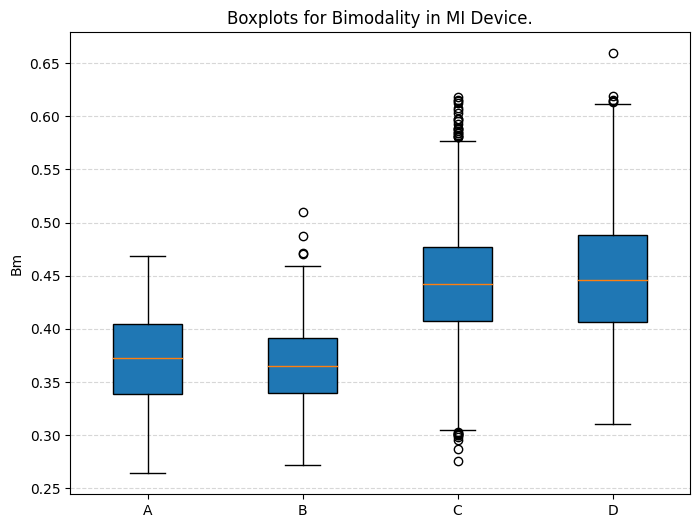

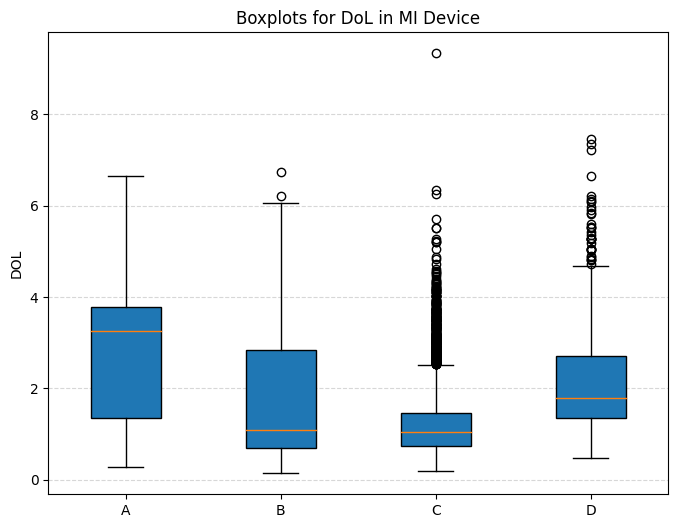

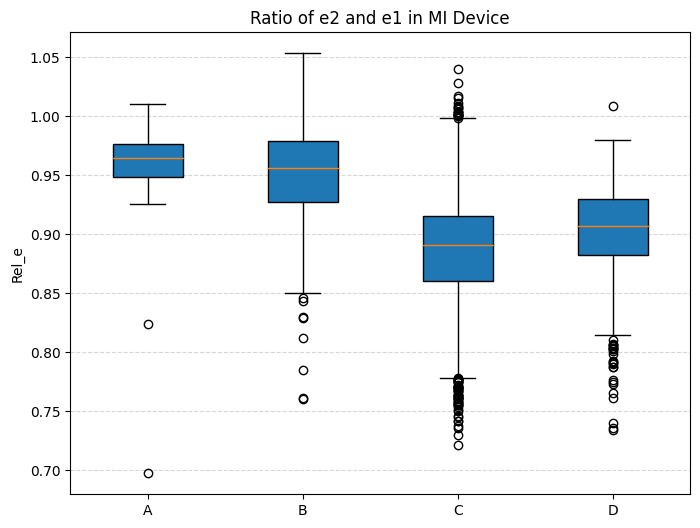

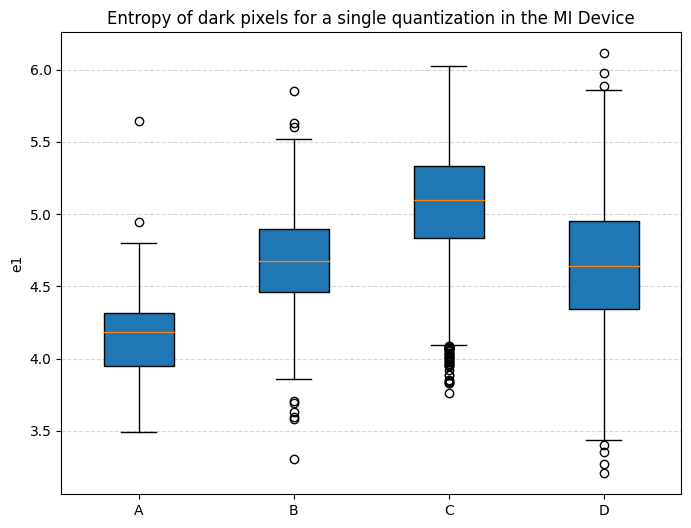

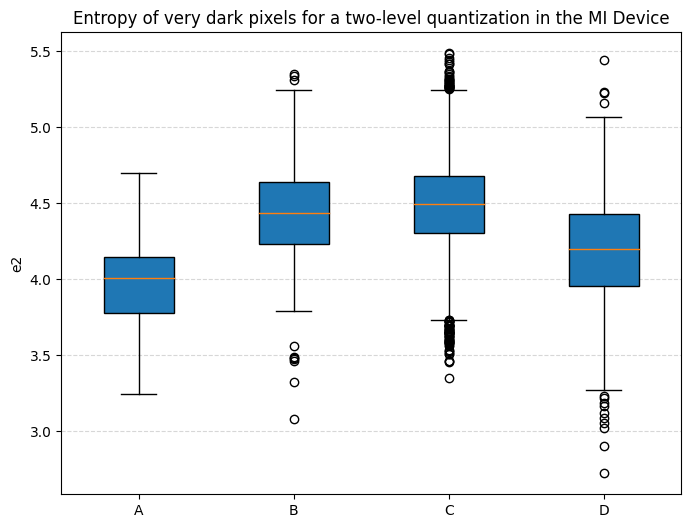

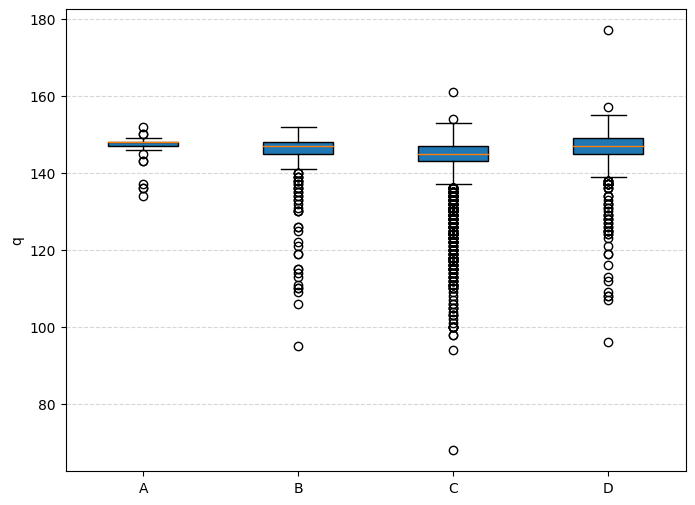

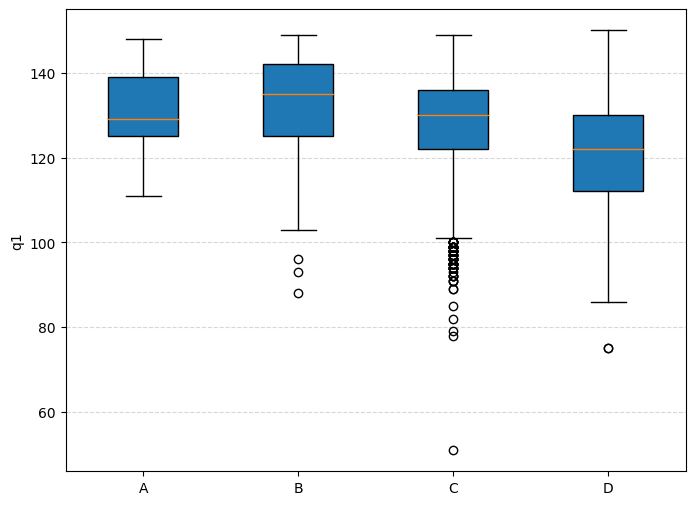

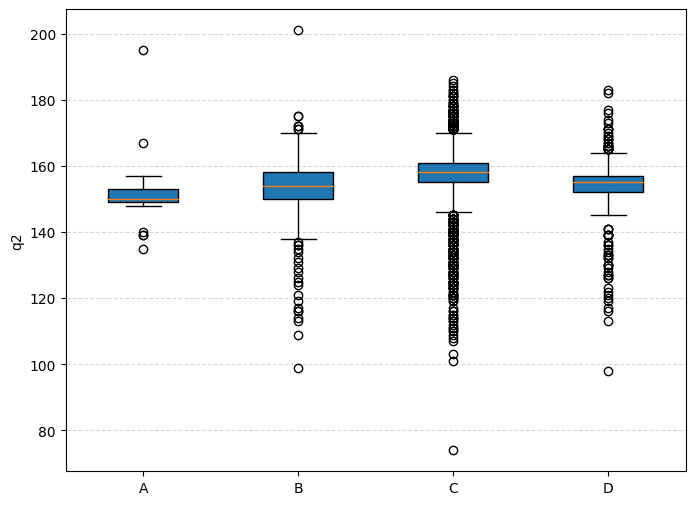

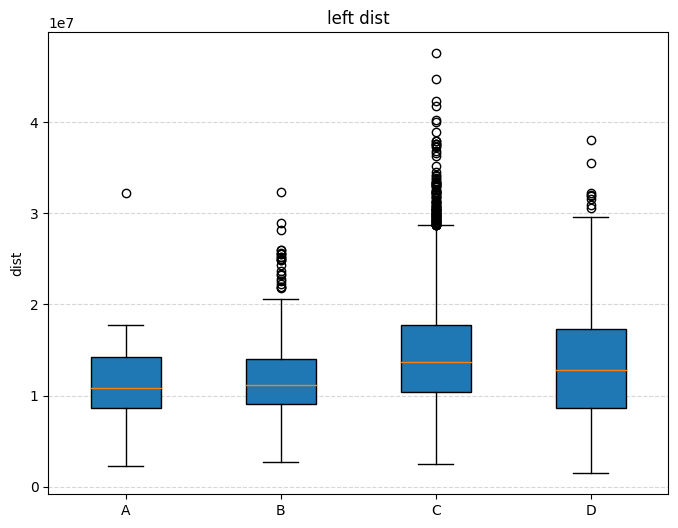

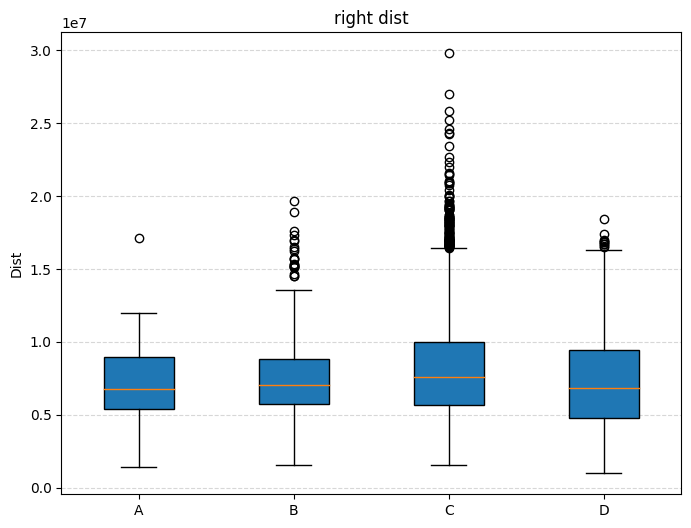

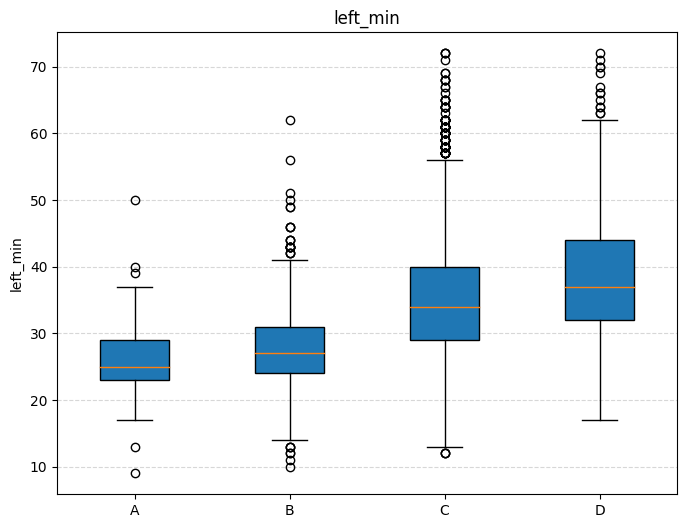

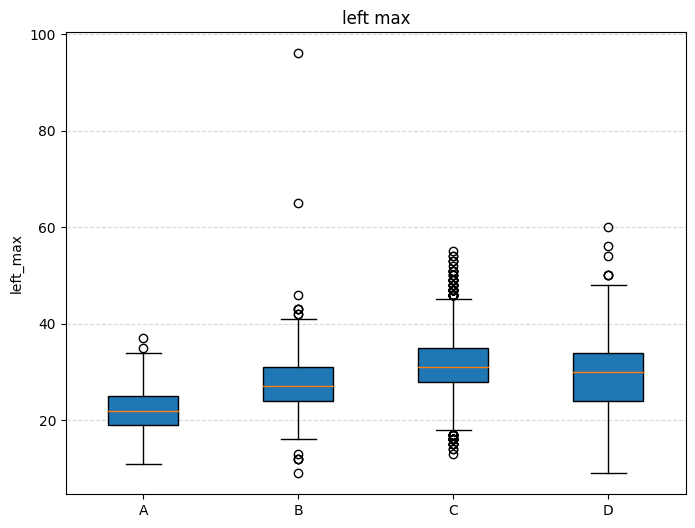

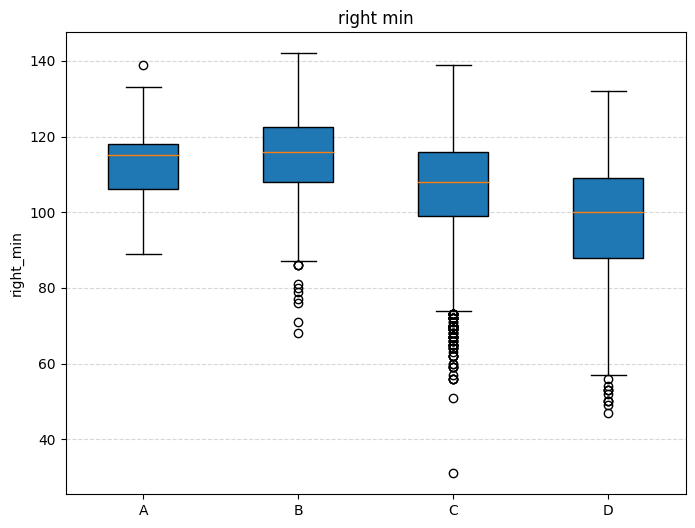

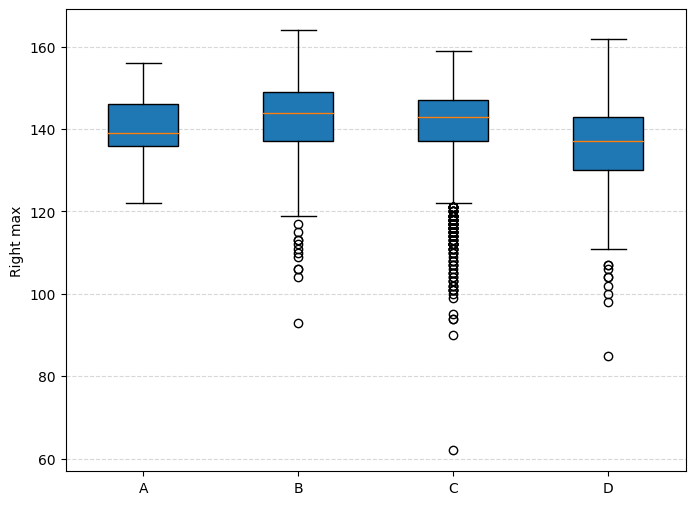

In [66]:
# bm, dol, rel_e, e1, e2, Q, Q1, Q2,E1, E2, left_dist, right_dist, left_min, left_max, right_min, right_max))


############################### 1 ########################################
plt.figure(figsize=(8, 6))
plt.boxplot([A[:,0], B[:,0], C[:,0], D[:,0]], labels=['A', 'B', 'C', 'D'], patch_artist=True)

plt.title("Boxplots for Bimodality in MI Device.")
plt.ylabel("Bm")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
################################# 2 ######################################

plt.figure(figsize=(8, 6))
plt.boxplot([A[:,1], B[:,1], C[:,1], D[:,1]], labels=['A', 'B', 'C', 'D'], patch_artist=True)

plt.title("Boxplots for DoL in MI Device")
plt.ylabel("DOL")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##################################  3  #####################################

plt.figure(figsize=(8, 6))
plt.boxplot([A[:,2], B[:,2], C[:,2], D[:,2]], labels=['A', 'B', 'C', 'D'], patch_artist=True)

plt.title("Ratio of e2 and e1 in MI Device")
plt.ylabel("Rel_e")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
##################################  4  ###########################################

plt.figure(figsize=(8, 6))
plt.boxplot([A[:,3], B[:,3], C[:,3], D[:,3]], labels=['A', 'B', 'C', 'D'], patch_artist=True)

plt.title("Entropy of dark pixels for a single quantization in the MI Device")
plt.ylabel("e1")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##################################  5  ###########################################

plt.figure(figsize=(8, 6))
plt.boxplot([A[:,4], B[:,4], C[:,4], D[:,4]], labels=['A', 'B', 'C', 'D'], patch_artist=True)

plt.title("Entropy of very dark pixels for a two-level quantization in the MI Device")
plt.ylabel("e2")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##################################  6  ###########################################

plt.figure(figsize=(8, 6))
plt.boxplot([A[:,5], B[:,5], C[:,5], D[:,5]], labels=['A', 'B', 'C', 'D'], patch_artist=True)

plt.ylabel("q")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
##################################  7  ###########################################

plt.figure(figsize=(8, 6))
plt.boxplot([A[:,6], B[:,6], C[:,6], D[:,6]], labels=['A', 'B', 'C', 'D'], patch_artist=True)

plt.ylabel("q1")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##################################  8  ###########################################

plt.figure(figsize=(8, 6))
plt.boxplot([A[:,7], B[:,7], C[:,7], D[:,7]], labels=['A', 'B', 'C', 'D'], patch_artist=True)

plt.ylabel("q2")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##################################  9  ########################################
plt.figure(figsize=(8, 6))
plt.boxplot([A[:,8], B[:,8], C[:,8], D[:,8]], labels=['A', 'B', 'C', 'D'], patch_artist=True)

plt.title("left dist")
plt.ylabel("dist")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
###################################  10  ######################################

plt.figure(figsize=(8, 6))
plt.boxplot([A[:,9], B[:,9], C[:,9], D[:,9]], labels=['A', 'B', 'C', 'D'], patch_artist=True)

plt.title("right dist")
plt.ylabel("Dist")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##################################  11  #####################################

plt.figure(figsize=(8, 6))
plt.boxplot([A[:,10], B[:,10], C[:,10], D[:,10]], labels=['A', 'B', 'C', 'D'], patch_artist=True)

plt.title("left_min")
plt.ylabel("left_min")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
##################################  12   ###########################################

plt.figure(figsize=(8, 6))
plt.boxplot([A[:,11], B[:,11], C[:,11], D[:,11]], labels=['A', 'B', 'C', 'D'], patch_artist=True)

plt.title("left max")
plt.ylabel("left_max")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

###################################  13  ###########################################

plt.figure(figsize=(8, 6))
plt.boxplot([A[:,12], B[:,12], C[:,12], D[:,12]], labels=['A', 'B', 'C', 'D'], patch_artist=True)

plt.title("right min")
plt.ylabel("right_min")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

####################################  14  ###########################################

plt.figure(figsize=(8, 6))
plt.boxplot([A[:,13], B[:,13], C[:,13], D[:,13]], labels=['A', 'B', 'C', 'D'], patch_artist=True)

plt.ylabel("Right max")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
###########################################################################################


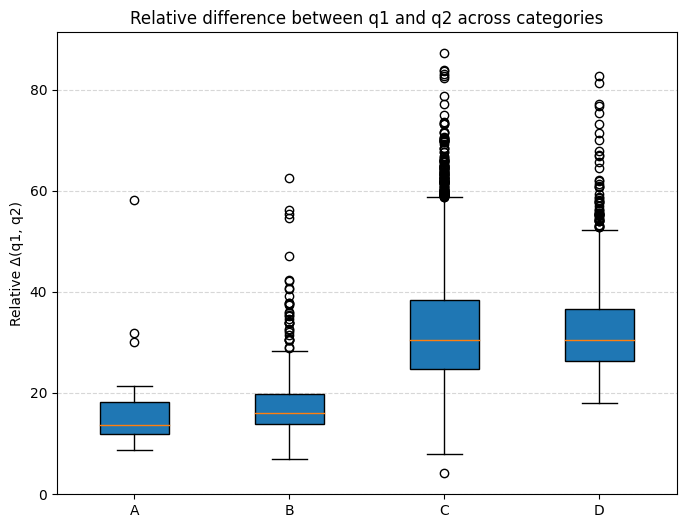

In [95]:
aa =  np.max([A[:, 0], 5*(1-A[:, 2])], axis=0)
bb =  np.max([B[:, 0], 5*(1-B[:, 2])], axis=0)
cc =  np.max([C[:, 0], 5*(1-C[:, 2])], axis=0)
dd =  np.max([D[:, 0], 5*(1-D[:, 2])], axis=0)

aa = aa*(100-A4)
bb = bb*(100-B4)
cc = cc*(100-C4)
dd = dd*(100-D4)


plt.figure(figsize=(8, 6))
plt.boxplot([aa, bb, cc, dd], labels=['A', 'B', 'C', 'D'], patch_artist=True)

plt.title("Relative difference between q1 and q2 across categories")
plt.ylabel("Relative Δ(q1, q2)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


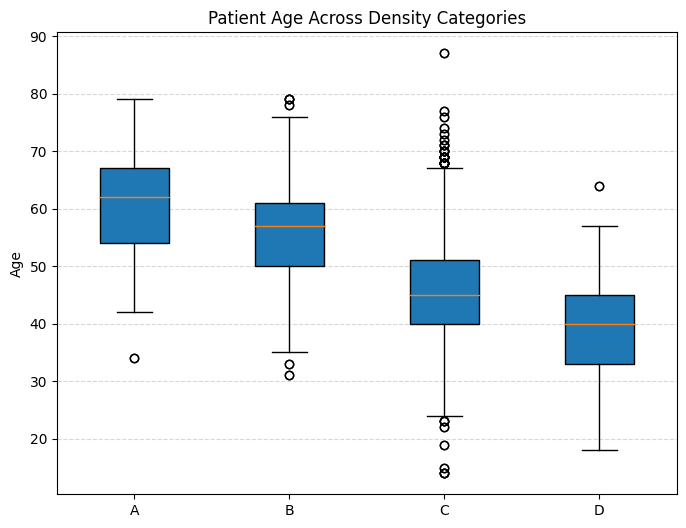

In [44]:
A4 = []
# Iterate through each image in the dataframe
for i, row in Dens_A.iloc[:].iterrows():
    age_str = metadata["Patient's Age"][i]  # e.g. '053Y'
    # Keep only digits
    age_clean = ''.join(filter(str.isdigit, age_str))
    # Convert to integer
    age_int = int(age_clean)
    A4.append(age_int)
    
B4 = []
# Iterate through each image in the dataframe
for i, row in Dens_B.iloc[:].iterrows():
    age_str = metadata["Patient's Age"][i]  # e.g. '053Y'
    # Keep only digits
    age_clean = ''.join(filter(str.isdigit, age_str))
    # Convert to integer
    age_int = int(age_clean)
    B4.append(age_int)
    
C4 = []
# Iterate through each image in the dataframe
for i, row in Dens_C.iloc[:].iterrows():
    age_str = metadata["Patient's Age"][i]  # e.g. '053Y'
    # Keep only digits
    age_clean = ''.join(filter(str.isdigit, age_str))
    # Convert to integer
    age_int = int(age_clean)
    C4.append(age_int)
    
D4 = []
# Iterate through each image in the dataframe
for i, row in Dens_D.iloc[:].iterrows():
    age_str = metadata["Patient's Age"][i]  # e.g. '053Y'
    # Keep only digits
    age_clean = ''.join(filter(str.isdigit, age_str))
    # Convert to integer
    age_int = int(age_clean)
    D4.append(age_int)
    
A4 = np.array(A4)
B4 = np.array(B4)
C4 = np.array(C4)
D4 = np.array(D4)
# Plotting the boxplot

plt.figure(figsize=(8, 6))
plt.boxplot([A4, B4, C4, D4], labels=['A', 'B', 'C', 'D'], patch_artist=True)

plt.title("Patient Age Across Density Categories")
plt.ylabel("Age")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [69]:
minA = np.avg(A[:, [6, 7]], axis=1)
minB = np.avg(B[:, [6, 7]], axis=1)
minC = np.min(C[:, [6, 7]], axis=1)
minD = np.min(D[:, [6, 7]], axis=1)

plt.figure(figsize=(8, 6))
plt.boxplot([minA, minB, minC, minD], labels=['A', 'B', 'C', 'D'], patch_artist=True)

plt.title("right dist")
plt.ylabel("Dist")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
######################333
maxA = np.max(A[:, [6, 7]], axis=1)
maxB = np.max(B[:, [6, 7]], axis=1)
maxC = np.max(C[:, [6, 7]], axis=1)
maxD = np.max(D[:, [6, 7]], axis=1)

plt.figure(figsize=(8, 6))
plt.boxplot([maxA, maxB, maxC, maxD], labels=['A', 'B', 'C', 'D'], patch_artist=True)

plt.title("right dist")
plt.ylabel("Dist")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
######################333
maxA = np.max(A[:, [8, 9]], axis=1)
maxB = np.max(B[:, [8, 9]], axis=1)
maxC = np.max(C[:, [8, 9]], axis=1)
maxD = np.max(D[:, [8, 9]], axis=1)

plt.figure(figsize=(8, 6))
plt.boxplot([maxA, maxB, maxC, maxD], labels=['A', 'B', 'C', 'D'], patch_artist=True)

plt.title("right dist")
plt.ylabel("Dist")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

AttributeError: module 'numpy' has no attribute 'avg'

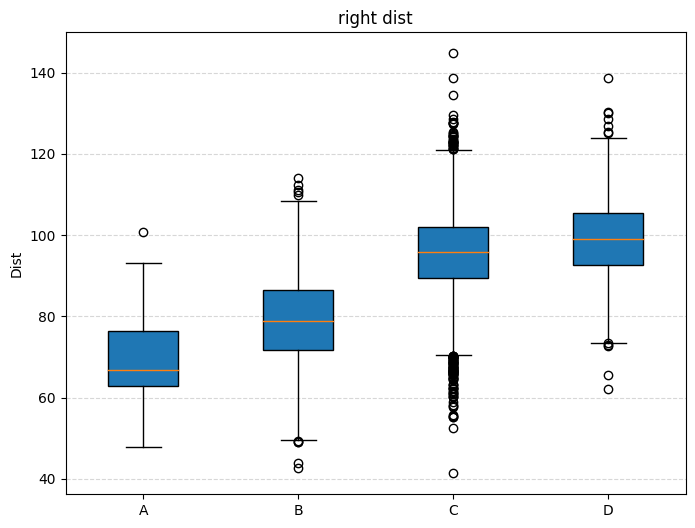

In [48]:
plt.figure(figsize=(8, 6))
plt.boxplot([100-A4+minA+2*A[:,3], 100-B4+minB+2*B[:,3], 100-C4+minC+2*C[:,3], 100-D4+minD+2*D[:,3]], labels=['A', 'B', 'C', 'D'], patch_artist=True)

plt.title("right dist")
plt.ylabel("Dist")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

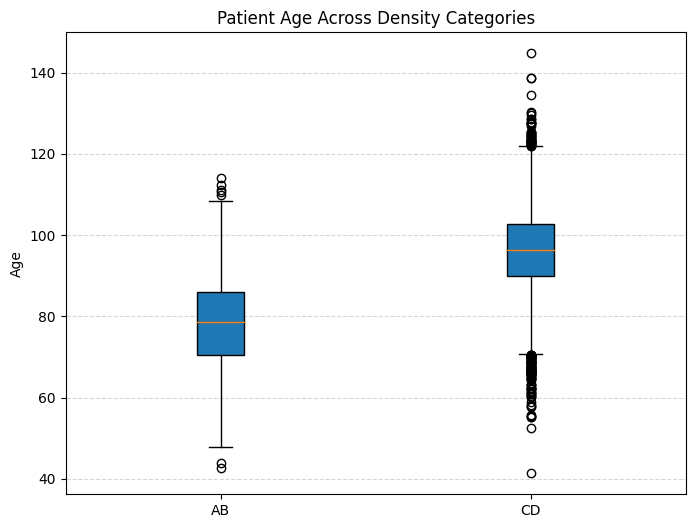

In [51]:
plt.figure(figsize=(8, 6))
plt.boxplot([np.concatenate((100-A4+minA+2*A[:,3], 100-B4+minB+2*B[:,3]), axis = 0), np.concatenate((100-C4+minC+2*C[:,3], 100-D4+minD+2*D[:,3]), axis = 0)], labels=['AB', 'CD'], patch_artist=True)

plt.title("Patient Age Across Density Categories")
plt.ylabel("Age")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


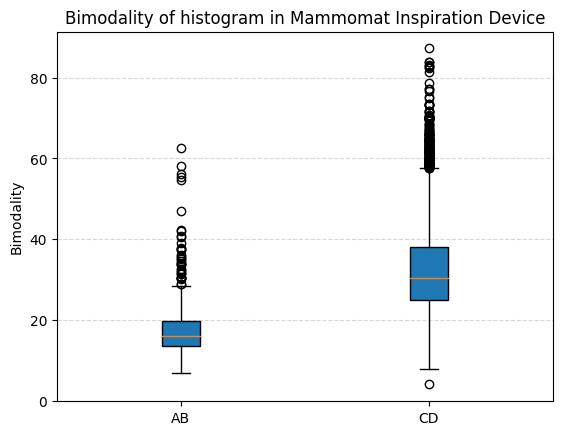

<Figure size 600x500 with 0 Axes>

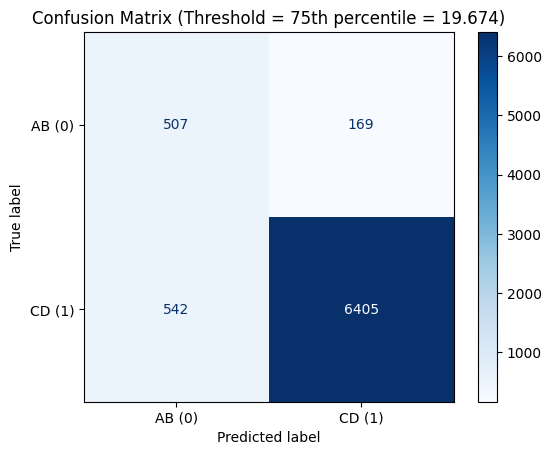

Threshold (75th percentile of AB): 19.674
Confusion Matrix:
 [[ 507  169]
 [ 542 6405]]
Accuracy : 0.9067
Precision: 0.9743
Recall   : 0.9220
F1-score : 0.9474


In [96]:

AB = np.concatenate((aa, bb), axis = 0)
CD = np.concatenate((cc, dd), axis = 0)


plt.boxplot([AB, CD], labels=['AB', 'CD'], patch_artist=True)

plt.title("Bimodality of histogram in Mammomat Inspiration Device")
plt.ylabel("Bimodality")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)

# Compute threshold (75th percentile of AB)
threshold = np.percentile(AB, 75)

# True labels (AB = 0, CD = 1)
y_true = np.concatenate((
    np.zeros(len(AB)),
    np.ones(len(CD))
))

# Predictions (based on threshold)
y_pred = np.concatenate((
    (AB >= threshold).astype(int),
    (CD >= threshold).astype(int)
))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['AB (0)', 'CD (1)'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix (Threshold = 75th percentile = {threshold:.3f})")
plt.show()

# Calculate performance metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print results
print(f"Threshold (75th percentile of AB): {threshold:.3f}")
print("Confusion Matrix:\n", cm)
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

